# from nacer-play

In [ ]:
%matplotlib widget 
import argparse
import copy
import gzip
import itertools
import os
import pickle
from collections import defaultdict
from itertools import count
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as anim
from multiprocessing import Pool

import random

In [ ]:
_dev = [torch.device('cpu')]
# tf = lambda x: torch.FloatTensor(x).to(_dev[0])
# tl = lambda x: torch.LongTensor(x).to(_dev[0])
tf = lambda x: torch.FloatTensor(np.array(x)).to(_dev[0])  # Convert to numpy array first
tl = lambda x: torch.LongTensor(np.array(x)).to(_dev[0])

def set_device(dev):
    _dev[0] = dev 

def func_corners(x):
    ax = abs(x)
    return (ax > 0.5).prod(-1) * 0.5 + ((ax < 0.8) * (ax > 0.6)).prod(-1) * 2 + 1e-1



# Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the dynamical system for the n-node system with sigmoid
def node_system_with_sigmoid(x, t, coord):
    matrix_dim = len(x)
    M_tilde = np.reshape(coord, (matrix_dim, matrix_dim))
    z = M_tilde.dot(x)  # Compute M_tilde * x
    sigmoid_z = sigmoid(z)
    dxdt = sigmoid_z - x  # Compute the derivative   
    return dxdt

# Calculate reward given the weights
def reward_oscillator(coord, ndim):
    delta = 0.0001  # 0.0001
    matrix_dim = int(np.sqrt(ndim))
    x0 = np.linspace(0, 1, matrix_dim, endpoint=False)  # Initial conditions
    t = np.linspace(0, 20, 200)  # Define the time points
    sol = odeint(node_system_with_sigmoid, x0, t, args=(coord, ))
    
    # Calculate the total number of sharp peaks across all time series
    total_peaks = 0
    for i in range(matrix_dim):  # Loop through each time series x1, x2, ..., xn
        x_i = sol[:, i]
        dx_i = np.diff(x_i)  # First derivative approximation
        peaks = 0
        for j in range(1, len(dx_i)):
            if dx_i[j-1] > 0 and dx_i[j] < 0:  # Detect a peak
                sharpness = x_i[j] - (x_i[j-1] + x_i[j+1]) / 2
                if sharpness > delta:  # Check if the peak is sharp
                    peaks += 1
        total_peaks += peaks  # Add the number of sharp peaks for this time series
    
    if total_peaks == 0:
        return 1  # 1 for zero peaks
    else:
        return 3 * 10**total_peaks  # 3*10^1, 3*10^2, ... for 1, 2, ... peaks


In [ ]:

class GridEnv:

    def __init__(self, horizon, ndim=2, func=None):
        self.horizon = horizon
        self.ndim = ndim
        self.func = func   # Sets the reward function.
        self._true_density = None
 
    def obs(self, s=None):
        """
        Returns a one-hot encoded observation of the current state.
        The observation is a flattened vector representing the agent's position in the grid.
        """
        s = np.int32(self._state if s is None else s)
        z = np.zeros((self.horizon * self.ndim), dtype=np.float32)
        z[np.arange(len(s)) * self.horizon + s] = 1 
        return z    # one-hot agent's current position in the grid.
    
    def s2x(self, s):
        """
        Transform the grid of indices (state s) to spherical coordinates and then calculate the cartesian coordinates
        (x_1, x_2, ..., x_n) for n dimensions.
        
        s[0]: radial distance (r)
        s[1:n-1]: polar angles (theta_1, theta_2, ..., theta_{n-2})
        s[n-1]: azimuthal angle (phi)
        """
        # Initialize the radius (r) from the first component of the state vector
        r = s[0]
    
        # Initialize an array to hold the Cartesian coordinates
        x = np.zeros(self.ndim)
    
        # Constants or parameters (assuming self.horizon refers to the number of steps in the grid)
        horizon = self.horizon
        
        # Calculate the spherical to Cartesian conversion
        product = r
        for i in range(1, self.ndim):
            if i == self.ndim - 1:
                # The last angle (phi) ranges from 0 to 2π
                phi = s[i] * 2 * np.pi / horizon
                x[i - 1] = product * np.cos(phi)
                x[i] = product * np.sin(phi)
            else:
                # The other angles (theta) range from 0 to π
                theta = s[i] * np.pi / horizon
                x[i - 1] = product * np.sin(theta)
                product *= np.cos(theta)
    
        return x
    
    def reset(self):
        """
        Resets the environment to the initial state.
        """
        self._state = np.int32([0] * self.ndim)   # start position (0,0...)
        self._step = 0
        return self.obs(), self.func(self.s2x(self._state), self.ndim), self._state

    def parent_transitions(self, s, used_stop_action):
        """
        Determines the parent states and corresponding actions that could have led to the current state.
        
        Parameters:
        - s: The current state.
        - used_stop_action: A boolean indicating if the stop action was used.
        
        Returns:
        - A list of possible parent states (one-hot encoded).
        - A list of corresponding actions.
        """
        if used_stop_action:
            return [self.obs(s)], [self.ndim]
            
        parents = []
        actions = []
        for i in range(self.ndim):
            if s[i] > 0:
                sp = s.copy()  # s + 0
                sp[i] -= 1
                if sp.max() == self.horizon - 1:  # Can't have a terminal parent
                    continue
                parents.append(self.obs(sp))  # Generate observation for parent state
                actions.append(i)
        return parents, actions

    
    def step(self, a):
        """
        Updates the environment's state based on the action `a` and 
        returns the new observation, reward, done signal, and new state.
        """
        s = self._state.copy()
        if a < self.ndim:
            s[a] += 1
        
        done = s.max() >= self.horizon - 1 or a == self.ndim
        self._state = s  # Update the internal state
        self._step += 1  # Increment step counter
        
        return self.obs(), 0 if not done else self.func(self.s2x(s), self.ndim), done, s



class ReplayBuffer:
    def __init__(self, args, env):
        self.buf = []
        self.strat = args.replay_strategy
        self.sample_size = args.replay_sample_size
        self.bufsize = args.replay_buf_size
        self.env = env

    def add(self, x, r_x):
        if self.strat == 'top_k':
            if len(self.buf) < self.bufsize or r_x > self.buf[0][0]:
                self.buf = sorted(self.buf + [(r_x, x)])[-self.bufsize:]

    def sample(self):
        if not len(self.buf):
            return []
        idxs = np.random.randint(0, len(self.buf), self.sample_size)
        return sum([self.generate_backward(*self.buf[i]) for i in idxs], [])  # Samples from the buffer and generates trajectories backward.

    def generate_backward(self, r, s0):
        s = np.int8(s0)
        os0 = self.env.obs(s)
        # If s0 is a forced-terminal state, the the action that leads
        # to it is s0.argmax() which .parents finds, but if it isn't,
        # we must indicate that the agent ended the trajectory with
        # the stop action
        used_stop_action = s.max() < self.env.horizon - 1
        done = True
        # Now we work backward from that last transition
        traj = []
        while s.sum() > 0:
            parents, actions = self.env.parent_transitions(s, used_stop_action)
            # add the transition
            traj.append([tf(i) for i in (parents, actions, [r], [self.env.obs(s)], [done])])
            # Then randomly choose a parent state
            if not used_stop_action:
                i = np.random.randint(0, len(parents))
                a = actions[i]
                s[a] -= 1
            # Values for intermediary trajectory states:
            used_stop_action = False
            done = False
            r = 0
        return traj  # Generates a trajectory by working backward from a terminal state.

def make_mlp(l, act=nn.LeakyReLU(), tail=[]):
    return nn.Sequential(*(sum(
        [[nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))
    
class FlowNetAgent:
    def __init__(self, args, envs):
        self.model = make_mlp([args.horizon * args.ndim] +
                              [args.n_hid] * args.n_layers +
                              [args.ndim+1])
        self.model.to(args.dev)
        self.target = copy.deepcopy(self.model)
        self.envs = envs
        self.ndim = args.ndim
        self.tau = args.bootstrap_tau
        self.replay = ReplayBuffer(args, envs[0])

    def parameters(self):
        return self.model.parameters()

    def sample_many(self, mbsize, all_visited_done):
        """Collects transition data from multiple parallel trajectories."""
        batch = []  # store transitions.
        batch += self.replay.sample()
        s = tf([i.reset()[0] for i in self.envs])
        done = [False] * mbsize
        while not all(done):
            # Note to self: this is ugly, ugly code
            with torch.no_grad():
                acts = Categorical(logits=self.model(s)).sample()   # Samples actions based on model's logits.
            step = [i.step(a) for i,a in zip([e for d, e in zip(done, self.envs) if not d], acts)]
            p_a = [self.envs[0].parent_transitions(sp_state, a == self.ndim)
                   for a, (sp, r, done, sp_state) in zip(acts, step)]
            batch += [[tf(i) for i in (p, a, [r], [sp], [d])]
                      for (p, a), (sp, r, d, _) in zip(p_a, step)]
            c = count(0)
            m = {j:next(c) for j in range(mbsize) if not done[j]}
            done = [bool(d or step[m[i]][2]) for i, d in enumerate(done)]
            s = tf([i[0] for i in step if not i[2]])
            for (_, r, d, sp) in step:
                if d:
                    all_visited_done.append((tuple(sp), r))  # (state, reward) pairs
                    self.replay.add(tuple(sp), r) 
        return batch  # it returns a batch of collected transitions for training. {parents, actions, reward, next_state, done}

    def sample_one_traj(self):
        """
        Samples a single trajectory and returns it.
        """
        traj = []
        env = self.envs[0]
        traj.append([[], [], 0, np.int32([0] * self.ndim), False])
        
        s = tf(env.reset()[0])
        done = False
        while not done:
            with torch.no_grad():
                logits = self.model(s.unsqueeze(0))
                action_dist = Categorical(logits=logits)
                a = action_dist.sample().item()
            sp, r, done_flag, sp_state = env.step(a)
            parent_states, parent_actions = env.parent_transitions(sp_state,
                                                                   a == self.ndim)
            traj.append([parent_states, parent_actions, r, sp_state, done_flag])
            
            s = tf(sp)
            done = done_flag
        return traj

    def learn_from(self, it, batch):
        loginf = tf([1000])
        batch_idxs = tl(sum([[i]*len(parents) for i, (parents,_,_,_,_) in enumerate(batch)], []))
        parents, actions, r, sp, done = map(torch.cat, zip(*batch))
        parents_Qsa = self.model(parents)[torch.arange(parents.shape[0]), actions.long()]
        in_flow = torch.log(torch.zeros((sp.shape[0],))
                            .index_add_(0, batch_idxs, torch.exp(parents_Qsa)))
        if self.tau > 0:
            with torch.no_grad(): next_q = self.target(sp)
        else:
            next_q = self.model(sp)
        next_qd = next_q * (1-done).unsqueeze(1) + done.unsqueeze(1) * (-loginf)
        out_flow = torch.logsumexp(torch.cat([torch.log(r)[:, None], next_qd], 1), 1)
        loss = (in_flow - out_flow).pow(2).mean()

        with torch.no_grad():
            term_loss = ((in_flow - out_flow) * done).pow(2).sum() / (done.sum() + 1e-20)
            flow_loss = ((in_flow - out_flow) * (1-done)).pow(2).sum() / ((1-done).sum() + 1e-20)

        if self.tau > 0:
            for a,b in zip(self.model.parameters(), self.target.parameters()):
                b.data.mul_(1-self.tau).add_(self.tau*a)

        return loss, term_loss, flow_loss    




In [ ]:
# Training 

def make_opt(params, args):
    params = list(params)
    if not len(params):
        return None
    if args.opt == 'adam':
        opt = torch.optim.Adam(params, args.learning_rate,
                               betas=(args.adam_beta1, args.adam_beta2))
    elif args.opt == 'msgd':
        opt = torch.optim.SGD(params, args.learning_rate, momentum=args.momentum)
    return opt

def compute_empirical_reward_distribution(visited):
    if not len(visited):
        return {}
    reward_hist = defaultdict(int)
    for _, reward in visited:
        reward_hist[reward] += 1
    total_visits = sum(reward_hist.values())
    empirical_distribution = {reward: count / total_visits for reward, count in reward_hist.items()}
    return empirical_distribution



all_losses = []
all_visited_done = []

def main(args):
    args.dev = torch.device(args.device)
    set_device(args.dev)
    f = {'default': None,
         'corners': func_corners,
         'oscillator': reward_oscillator,
    }[args.func]
    
    env = GridEnv(args.horizon, args.ndim, func=f)
    envs = [GridEnv(args.horizon, args.ndim, func=f)
            for i in range(args.mbsize)] 
    ndim = args.ndim
    nnode = args.nnode

    if args.method == 'flownet':
        agent = FlowNetAgent(args, envs)
    elif args.method == 'mcmc':
        agent = MHAgent(args, envs)
    elif args.method == 'random_traj':
        agent = RandomTrajAgent(args, envs)

    opt = make_opt(agent.parameters(), args)

        
    
    # Log file setup
    log_file_path = f'training_output_{args.nnode}-node.log'
    with open(log_file_path, 'w') as log_file:
    
        # Training Loop Setup
        
        ttsr = max(int(args.train_to_sample_ratio), 1) # train to sample ratio
        sttr = max(int(1/args.train_to_sample_ratio), 1) # sample to train ratio
        
        for i in tqdm(range(args.n_train_steps+1), disable=not args.progress):
            data = []  # a list of transitions from a batch of trajectories
            for j in range(sttr):
                """Agent samples trajectories for training."""
                data += agent.sample_many(args.mbsize, all_visited_done)   
            for j in range(ttsr):
                """Agent updates its model using the sampled data."""
                losses = agent.learn_from(i * ttsr + j, data) # returns (opt loss, *metrics)
                if losses is not None:
                    losses[0].backward()
                    if args.clip_grad_norm > 0:
                        torch.nn.utils.clip_grad_norm_(agent.parameters(),
                                                       args.clip_grad_norm)
                    opt.step()
                    opt.zero_grad()
                    all_losses.append([i.item() for i in losses])
        
            # Log empirical reward every 100 iterations
            if not i % 100:
                empirical_distribution = compute_empirical_reward_distribution(all_visited_done[-args.num_empirical_loss:])
                print('Empirical Reward Distribution:', empirical_distribution)
                log_file.write(f'Empirical Reward Distribution: {empirical_distribution}\n')
                log_file.flush()  # Ensure data is written to the log file
                        
            # Save the agent and model every 1000 iterations
            if not i % 1000:
                root = os.path.join(args.save_path, f"{nnode}-node")  # Create the directory for the specific model variation
                os.makedirs(root, exist_ok=True)  # Ensure the directory exists
            
                # Save the entire agent
                agent_save_path = os.path.join(root, f"agent_checkpoint_{i}.pkl.gz")  # Save agent checkpoint with iteration number
                with gzip.open(agent_save_path, 'wb') as f:  # Use gzip for compression
                    pickle.dump(agent, f)
                print(f"Agent checkpoint saved at iteration {i} in {nnode}.")
            
                # Save the agent's model separately
                model_save_path = os.path.join(root, f"model_checkpoint_{i}.pkl.gz")  # Save model checkpoint with iteration number
                with gzip.open(model_save_path, 'wb') as f:  # Use gzip for compression
                    pickle.dump(agent.model, f)
                print(f"Model checkpoint saved at iteration {i} in {nnode}.")
            
            

In [ ]:
class Args:
    save_path = 'results-nacer'
    device = 'cpu'
    progress = True  
    method = 'flownet'
    learning_rate = 1e-3
    opt = 'adam'
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    momentum = 0.9  # SGD with momentum
    mbsize = 16  # number of parallel environments (trajectories) are collected by one agent (One Agent's model is shared in Many Environments). 
    train_to_sample_ratio = 0.5  # determines how many times the agent should update its model (train) for each set of data it collects from the environment. 
    clip_grad_norm = 0.
    n_hid = 256  # number of hidden units in each hidden layer
    n_layers = 2
    n_train_steps = 30000 
    num_empirical_loss = 60000 # number of samples used to compute the empirical distribution loss during evaluation.
    
    
    # Env
    func = 'oscillator'
    horizon = 20  # 4*5 
    nnode = 5
    ndim = nnode*nnode 
    
    # Flownet
    bootstrap_tau = 0.0  # implies no bootstrapping, meaning the target network isn't being updated gradually but possibly replaced entirely at some point.
    replay_strategy = 'top_k'  # 'top_k' or 'none'
    replay_sample_size = 3  # number of experiences to sample from the replay buffer at each update step.
    replay_buf_size = 100  #  size of the replay buffer, which stores past experiences for the agent to learn from.



args = Args()
torch.set_num_threads(50)
#main(args)



In [ ]:
import pickle
args = Args()
# Load the trained_agent object from the file
args.save_path_agent = "results-danny/5-node/agent_checkpoint_30000.pkl"
with open(args.save_path_agent, 'rb') as f:
    trained_agent = pickle.load(f)
print(trained_agent)

In [ ]:
trained_agent.model

Sequential(
  (0): Linear(in_features=500, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=26, bias=True)
)

In [ ]:
env = GridEnv(20, ndim=25, func=None)



def get_states(traj_):
    states = [0 for i in range(len(traj_))]
        
    for i in range(len(traj_)):
        states[i] = env.s2x(traj_[i][3])
    states = np.asarray(states)
    
    return states

def get_many_traj_states(tmp):
    torch.seed()#manual_seed(int(tmp))    
    #random.seed(int(tmp))
    #np.random.seed(int(tmp))
    traj_ = trained_agent.sample_one_traj()
    l_r = np.log10(traj_[-1][2]+1E-10)
        
    states = get_states(traj_)
            
    return l_r, states

N_peaks = 8
N_states = 500
state_count = 0
states = [0 for i in range(N_states)]
size = 200

pool = Pool(processes=size)
with tqdm(total=N_states) as pbar:
    while state_count < N_states:
        
        
        r = list(pool.imap(get_many_traj_states, 
                                np.random.randint(0, high=1E14, size=size), 
                                chunksize=1))

        for i in range(size):
            if (r[i][0] > N_peaks) and (r[i][0]<N_peaks+1):
                states[state_count] = r[i][1]
                state_count += 1
                pbar.update(1)

                """
                if state_count > 1:
                    dist = np.sqrt(np.sum((states[state_count-1][-1] - states[0][-1])**2))/25.0
                    if dist > 0.6:
                        state_count -= 1
                        pbar.update(-1)
                        print(dist)
                """
            
    
#with open("5-node_"+str(N_peaks)+"-peaks_"+str(N_traj)+"-trj", "wb") as f:
#    pickle.dump(all_states, f)

100%|█████████████████████████████████████████| 500/500 [06:22<00:00,  1.31it/s]


In [ ]:
all_states = states

In [ ]:
all_states_flat = np.concatenate(tuple(all_states), axis=0)

In [ ]:
all_states_flat.shape

(64521, 25)

0
0
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


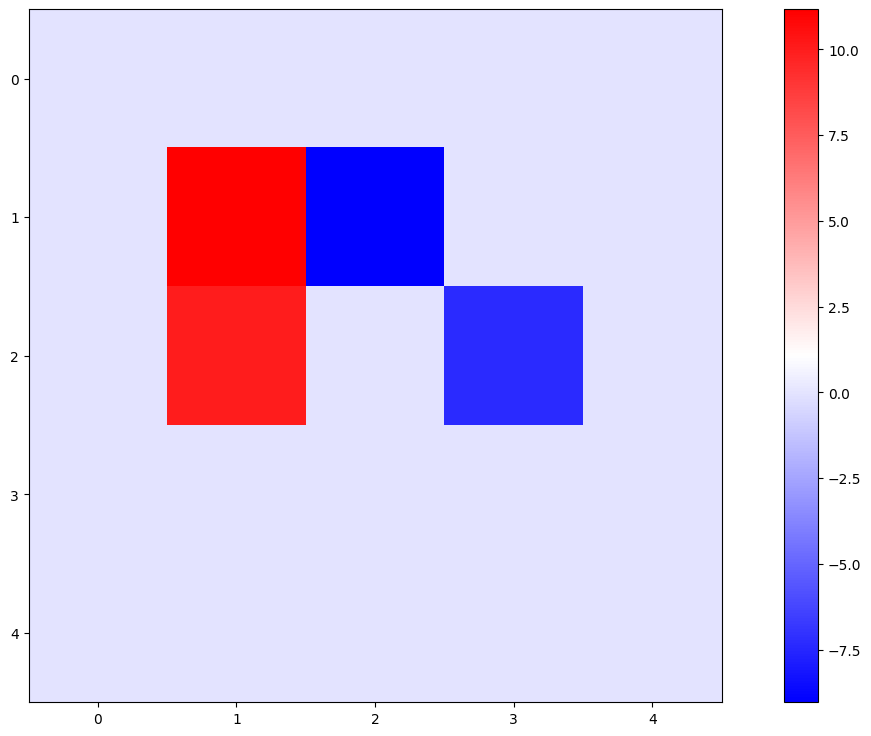

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

im = ax.imshow(states[0].reshape(5, 5), cmap="bwr", vmin=np.min(states), vmax=np.max(states))
plt.colorbar(im)

def update(t):
    print(t)
    im.set_data(states[t].reshape(5, 5))

    return im,

ani = anim.FuncAnimation(fig, update, frames=len(traj_), interval=100, blit=True)
ani.save("test_movie_agent.mp4")


In [ ]:
import umap # pacmap
import pacmap # pacmap
import phate # pacmap

embedding = pacmap.PaCMAP(n_neighbors=1000, verbose=True).fit_transform(all_states_flat)
#embedding = phate.PHATE(knn=1000, t=3, n_jobs=-1, verbose=True).fit_transform(all_states_flat)
#embedding = umap.UMAP(n_neighbors=1000, n_jobs=-1, low_memory=False, verbose=True).fit_transform(all_states_flat)

X is normalized
PaCMAP(n_neighbors=1000, n_MN=500, n_FP=2000, distance=euclidean, lr=1.0, n_iters=450, apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((64521000, 2), (32260500, 2), (129042000, 2))
Initial Loss: 14680064.0
Iteration:   10, Loss: 27617516.000000
Iteration:   20, Loss: 26043624.000000
Iteration:   30, Loss: 25368352.000000
Iteration:   40, Loss: 24548112.000000
Iteration:   50, Loss: 24118116.000000
Iteration:   60, Loss: 23782808.000000
Iteration:   70, Loss: 23324812.000000
Iteration:   80, Loss: 22242586.000000
Iteration:   90, Loss: 20879262.000000
Iteration:  100, Loss: 17348192.000000
Iteration:  110, Loss: 22458148.000000
Iteration:  120, Loss: 22372694.000000
Iteration:  130, Loss: 22203564.000000
Iteration:  140, Loss: 22244220.000000


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=200)

cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
for i in range(0, N_states):
    offset=0
    for j in range(0, i-1):
        offset+=len(all_states[j])
    #im  = ax.plot(*embedding[offset:offset+len(all_states[i]), :].T, color="k", lw=0.1)
    im  = ax.scatter(*embedding[offset:offset+len(all_states[i]), :].T, s=5,
                     c=np.arange(0, len(all_states[i]), 1), cmap="bwr")

plt.colorbar(im)
#plt.show()
plt.savefig("tmp_pmap.png")

In [ ]:
import umap # pacmap
import pacmap # pacmap
import phate # pacmap


embedding = phate.PHATE(n_components=3, knn=1000, t=3, verbose=True).fit_transform(all_states_flat)


In [ ]:
fig = plt.figure(figsize=(9, 9), dpi=100)
ax = fig.add_subplot(projection='3d')

for i in range(0, N_traj):
    offset=0
    for j in range(0, i-1):
        offset+=len(all_states[j])
    #im  = ax.plot(*embedding[offset:offset+len(all_states[i]), :].T, color="k", lw=0.01)
    im  = ax.scatter(*embedding[offset:offset+len(all_states[i]), :].T, s=5,
                     c=np.arange(0, len(all_states[i]), 1), cmap="bwr")


ax.view_init(50, 0)


def update(t):
    print(t)
    ax.view_init(50, t)

    return im,

ani = anim.FuncAnimation(fig, update, frames=180, interval=100, blit=True)
ani.save("3d_phate_5-peaks.mp4")


#plt.colorbar(im)
plt.show()

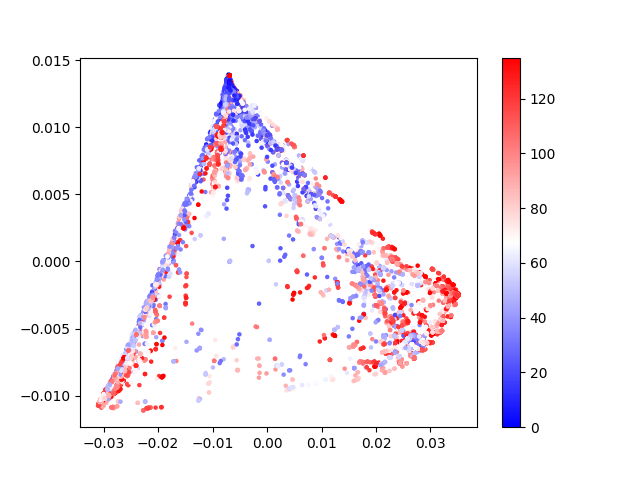

In [ ]:
fig, ax = plt.subplots(1, 1)

for i in range(0, N_traj):
    offset=0
    for j in range(0, i-1):
        offset+=len(all_states[j])
    #im  = ax.plot(*embedding[offset:offset+len(all_states[i]), :].T, color="k", lw=0.01)
    im  = ax.scatter(*embedding[offset:offset+len(all_states[i]), :].T, s=5,
                     c=np.arange(0, len(all_states[i]), 1), cmap="bwr")

plt.colorbar(im)
plt.show()

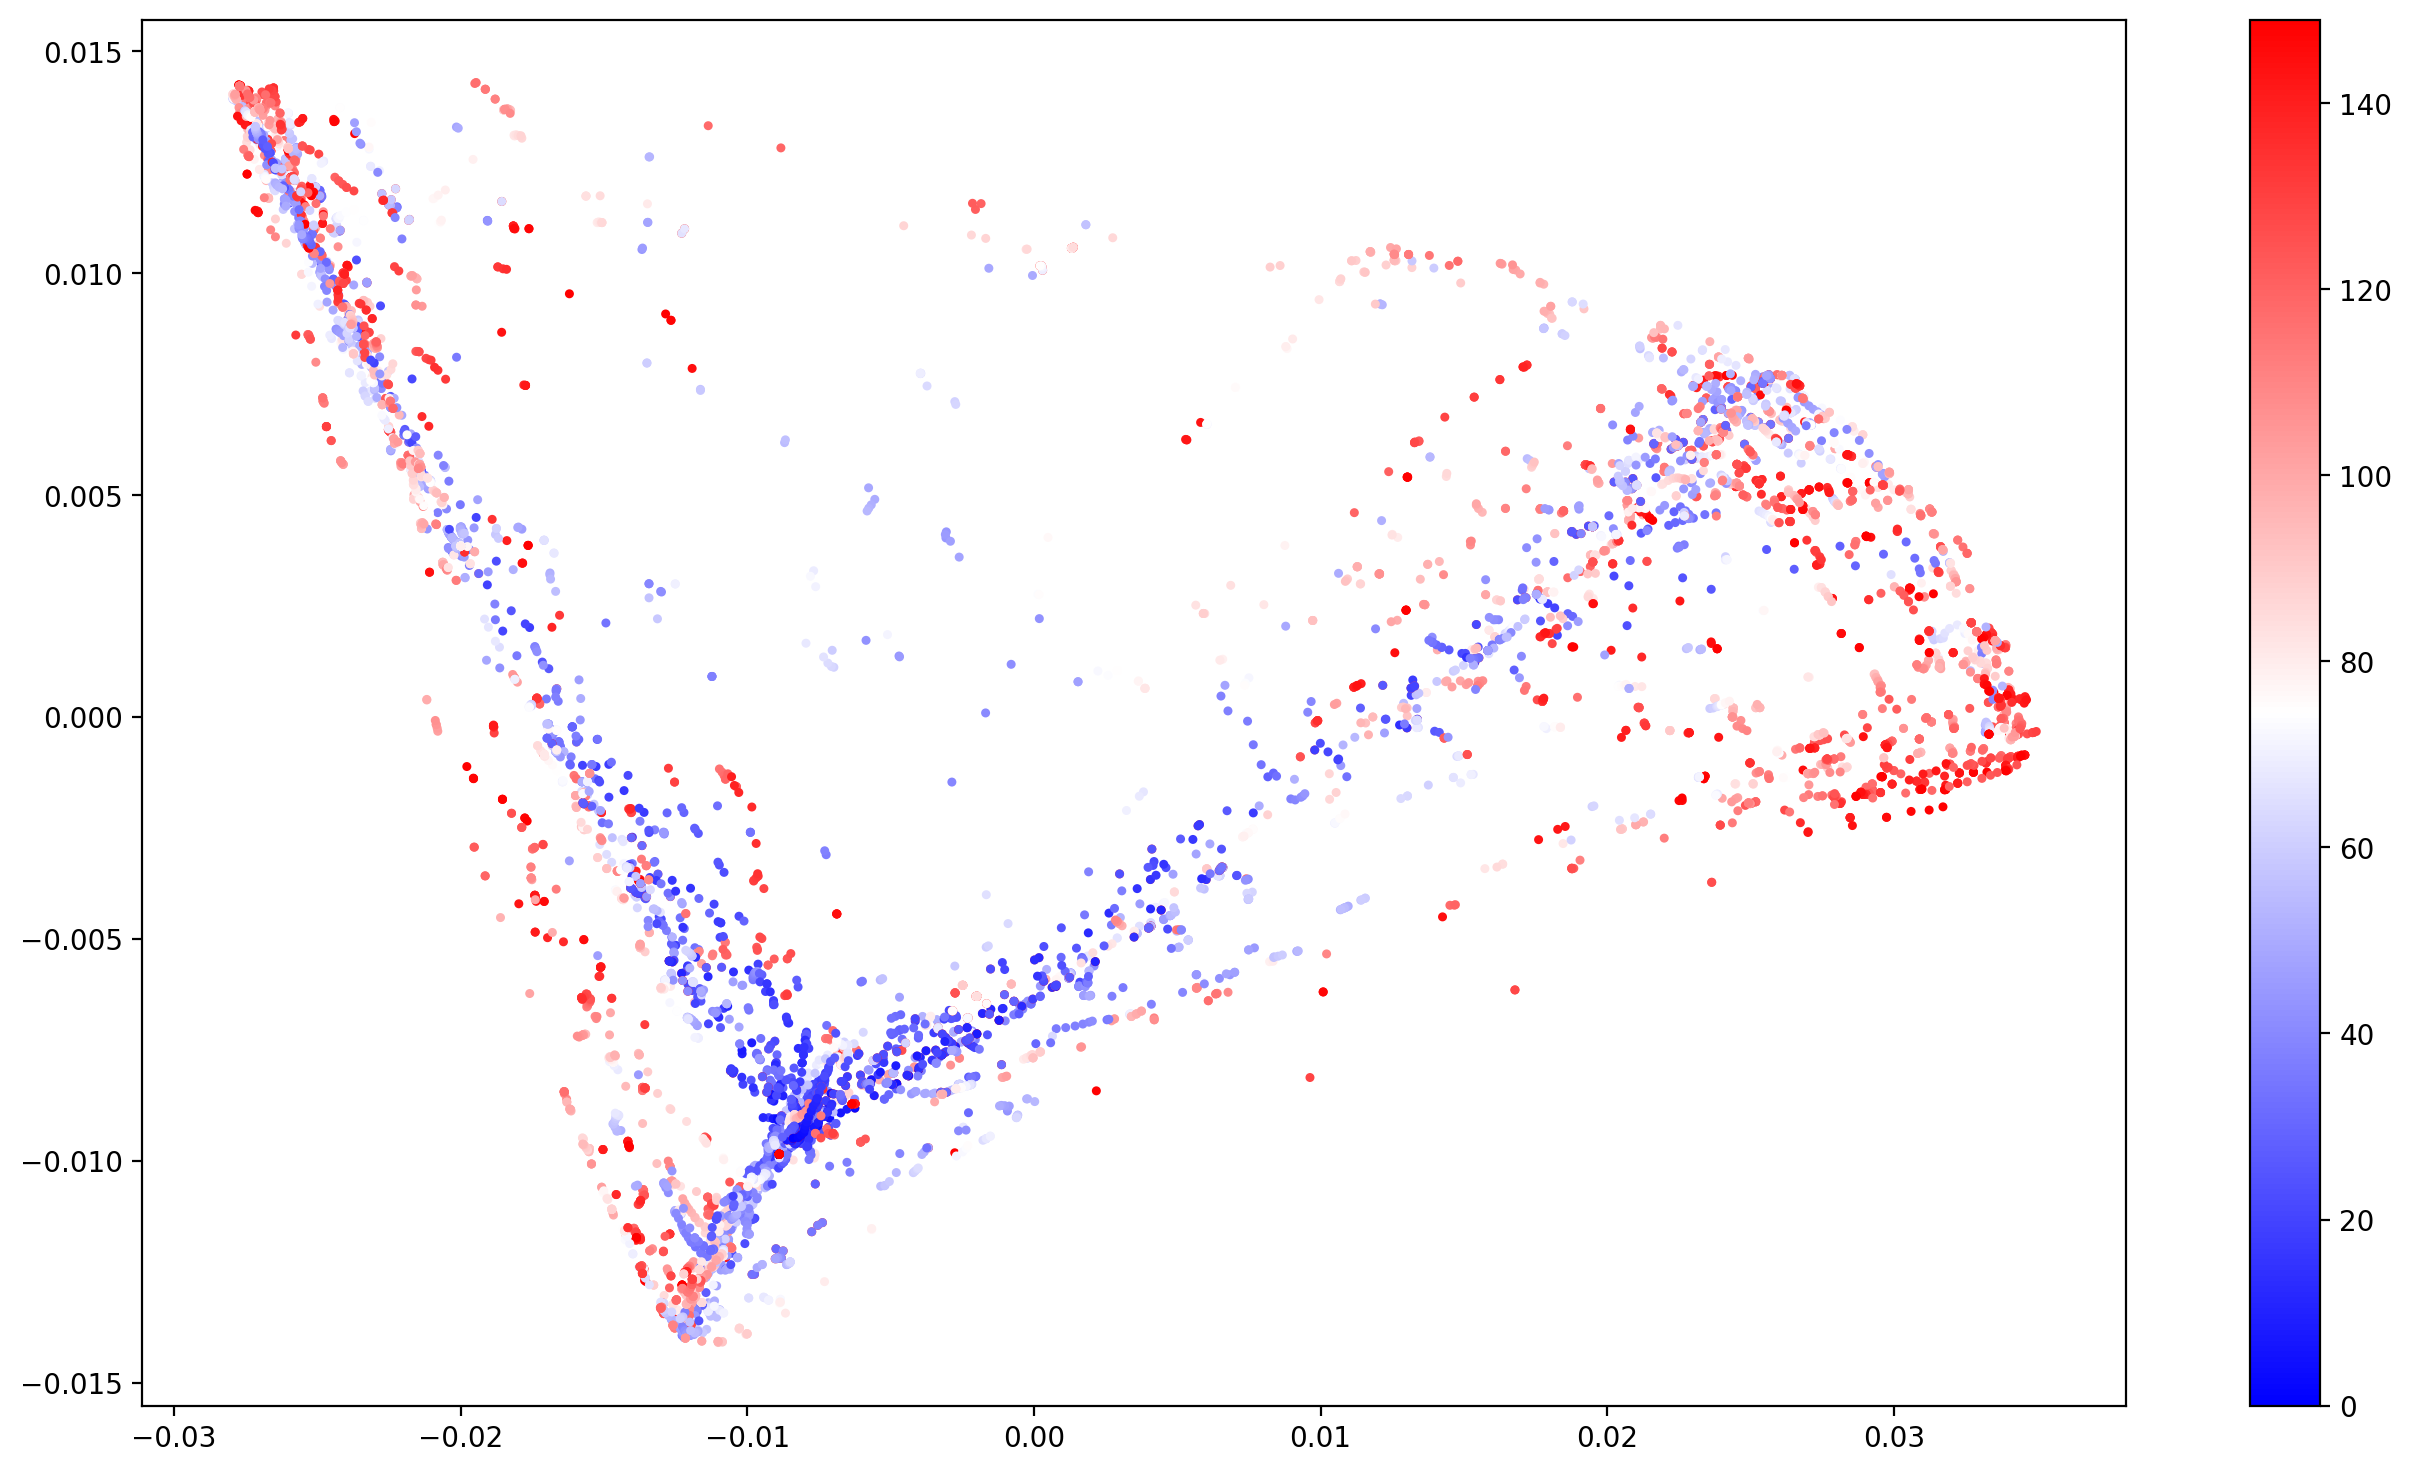

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=200)

for i in range(0, N_traj):
    offset=0
    for j in range(0, i-1):
        offset+=len(all_states[j])
    #im  = ax.plot(*embedding[offset:offset+len(all_states[i]), :].T, color="k", lw=0.01)
    im  = ax.scatter(*embedding[offset:offset+len(all_states[i]), :].T, s=5,
                     c=np.arange(0, len(all_states[i]), 1), cmap="bwr")

plt.colorbar(im)
plt.show()
#plt.savefig("evo_tree_8peaks_100_traj_PHATE.png")

# from PHATE

In [2]:
# %matplotlib widget 
import argparse
import copy
import gzip
import random


import argparse
import copy
import gzip
import heapq
import itertools
import os
import pickle
from collections import defaultdict
from itertools import count, chain


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm
from scipy.integrate import odeint
import ipywidgets as widgets
from ipywidgets import interact

torch.set_num_threads(100)



In [3]:



"""
What defines an appearance is thus just a list of these keys. 
"""

plus_max = 4
minus_max = 4
n_node = 3  
n_w = n_node*n_node
patches = {}
for w in range(n_w):
    for plus in range(1, plus_max + 1):
        patches[f'w{w}_plus{plus}'] = plus
    for minus in range(1, minus_max + 1):
        patches[f'w{w}_minus{minus}'] = -minus
sorted_keys = sorted(patches.keys())
sorted_keys.append('stop')  # Add 'stop' action to the sorted keys


def appearance_to_tensor(appearance):
    return torch.tensor([i in appearance for i in sorted_keys]).float()


def draw_appearance(appearance):
    weight_list = [0] * n_w
    for action in appearance:
        if action == 'stop':
            continue
        w, change = action.split('_')
        w_index = int(w[1:])
        if change.startswith('plus'):
            change_value = int(change[4:])
        elif change.startswith('minus'):
            change_value = -int(change[5:])
        weight_list[w_index] += change_value
    return weight_list







"""
We define a reward function to evaluate the quality of an appearance.
"""

def appearance_reward(appearance):
    weights_list = draw_appearance(appearance)
    ndim = len(weights_list)
    matrix_dim = int(np.sqrt(ndim))
    coord = np.array(weights_list)

    return reward_oscillator(coord, ndim)



def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the dynamical system for the n-node system with sigmoid
def node_system_with_sigmoid(x, t, coord):
    matrix_dim = len(x)
    M_tilde = np.reshape(coord, (matrix_dim, matrix_dim))
    z = M_tilde.dot(x)  # Compute M_tilde * x
    sigmoid_z = sigmoid(z)
    dxdt = sigmoid_z - x  # Compute the derivative   
    return dxdt

# Calculate reward given the weights
def reward_oscillator(coord, ndim):
    delta = 0.0001  # 0.0001
    matrix_dim = int(np.sqrt(ndim))
    xinit = np.linspace(0, 1, matrix_dim, endpoint=False)  # Initial conditions
    t = np.linspace(0, 20, 200)  # Define the time points   
    sol = odeint(node_system_with_sigmoid, xinit, t, args=(coord, ))
    
    # Calculate the number of sharp peaks for x1 (first time series)
    x1 = sol[:, 0]
    dx1 = np.diff(x1)  # First derivative approximation
    x1_peaks = 0
    for j in range(1, len(dx1)):
        if dx1[j-1] > 0 and dx1[j] < 0:  # Detect a peak
            sharpness = x1[j] - (x1[j-1] + x1[j+1]) / 2
            if sharpness > delta:  # Check if the peak is sharp
                x1_peaks += 1
    
    if x1_peaks == 0:
        # return 1e-10  # 10^(-10) for zero peaks
        return 0
    else:
        # return x1_peaks*100**(x1_peaks-1)
        return x1_peaks
        







"""
We define a model to predict the edge flows (probability of transitioning to a child state).
"""
# We first define how the model will view an appearance, i.e. how to encode an appearance in a tensor
def appearance_to_tensor(appearance):
  return torch.tensor([i in appearance for i in sorted_keys]).float()

class FlowModel(nn.Module):
  def __init__(self, num_hid = 512):
    super().__init__()
    # We encoded the current state as binary vector, for each patch the associated
    # dimension is either 0 or 1 depending on the absence or precense of that patch.
    # Therefore the input dimension is n_w * (plus_max + minus_max) + 1 for the n_w * (plus_max + minus_max) patches plus the stop action.
    self.mlp = nn.Sequential(nn.Linear(n_w * (plus_max + minus_max) + 1, num_hid), 
                             nn.LeakyReLU(),
                             # We also output n_w * (plus_max + minus_max) + 1 numbers, since there are up to
                             # n_w * (plus_max + minus_max) possible actions plus the stop action.
                             nn.Linear(num_hid, n_w * (plus_max + minus_max) + 1))  
  def forward(self, x):
    # We take the exponential to get positive numbers, since flows must be positive,
    # and multiply by (1 - x) to give 0 flow to actions we know we can't take
    # (in this case, x[i] is 1 if a feature is already there, so we know we can't add it again).
    F = self.mlp(x).exp() * (1 - x)
    return F
  
  
  
  
  
  
  
  
"""
We need the parents of a state to compute the loss later.
"""

def appearance_parents(state):
  if 'stop' in state:
    return [state[:-1]], [sorted_keys.index('stop')]
  
  parent_states = []  # states that are parents of state
  parent_actions = []  # actions that lead from those parents to state
  for feature in state:
    # For each feature, there is a parent without that feature
    parent_states.append([i for i in state if i != feature])
    # The action to get there is the corresponding index of that feature
    parent_actions.append(sorted_keys.index(feature))
  return parent_states, parent_actions



# """
# Training 
# """

# # Instantiate model and optimizer
# F_sa = FlowModel()
# opt = torch.optim.Adam(F_sa.parameters(), 3e-4)

# # Let's keep track of the losses and the appearances we sample
# losses = []
# sampled_appearances = []
# # To not complicate the code, I'll just accumulate losses here and take a
# # gradient step every `update_freq` episode.
# minibatch_loss = 0
# update_freq = 16
# n_steps = 10
# save_freq = 20000
# reward_func = "x1_peaks"  # "x1_peaks*100**(x1_peaks-1)"
# save_path = f'result/v0-{n_node}nodes-{n_steps}steps-{reward_func}' 
# os.makedirs(save_path, exist_ok=True)
# log_file = os.path.join(save_path, 'training_log.txt')

# for episode in tqdm.tqdm(range(600000), ncols=40):
#   state = []  # Each episode starts with an "empty state"
#   edge_flow_prediction = F_sa(appearance_to_tensor(state))  # Predict F(s, a)
#   for t in range(n_steps):
#     policy = edge_flow_prediction / edge_flow_prediction.sum()
#     action = Categorical(probs=policy).sample()
#     new_state = state + [sorted_keys[action]]

#     # Now we want to compute the loss, we'll first enumerate the parents
#     parent_states, parent_actions = appearance_parents(new_state)
#     # And compute the edge flows F(s, a) of each parent
#     px = torch.stack([appearance_to_tensor(p) for p in parent_states])
#     pa = torch.tensor(parent_actions).long()
#     parent_edge_flow_preds = F_sa(px)[torch.arange(len(parent_states)), pa]
#     # Now we need to compute the reward and F(s, a) of the current state,
#     # which is currently `new_state`
#     if t == n_steps - 1 or sorted_keys[action] == 'stop':
#       # If we've built a complete appearance or chosen to stop, we're done, so the reward is > 0
#       # (unless the appearance is invalid)
#       reward = appearance_reward(new_state)
#       # and since there are no children to this state F(s,a) = 0 \forall a
#       edge_flow_prediction = torch.zeros(n_w * (plus_max + minus_max) + 1)
#       # print("stop herere ... ", sorted_keys[action])
#     else:
#       # Otherwise we keep going, and compute F(s, a)
#       reward = 0
#       edge_flow_prediction = F_sa(appearance_to_tensor(new_state))

#     # The loss as per the equation above
#     flow_mismatch = (parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward).pow(2)
#     minibatch_loss += flow_mismatch  # Accumulate
    
#     # Continue iterating ?
#     state = new_state
#     if sorted_keys[action] == 'stop':
#       break  # stop the inner loop if stop is chosen   
    
    
#   # We're done with the episode, add the appearance and reward to the list.
#   sampled_appearances.append([state, reward])
  
#   # if we are at an update episode, take a gradient step.
#   if episode % update_freq == 0:
#     losses.append(minibatch_loss.item())
#     minibatch_loss.backward()
#     opt.step()
#     opt.zero_grad()
#     minibatch_loss = 0

#   # Save progress every save_freq episodes
#   if (episode + 1) % save_freq == 0:
#     torch.save(F_sa.state_dict(), os.path.join(save_path, f'model_episode_{episode+1}.pth'))
#     variables_to_save = {
#         'n_node': n_node,
#         'plus_max': plus_max,
#         'minus_max': minus_max,
#         'losses': losses,
#         'sampled_appearances': sampled_appearances,
#         'update_freq': update_freq,
#         'n_steps': n_steps,
#     }
#     with open(os.path.join(save_path, f'variables_episode_{episode+1}.pkl'), 'wb') as f:
#         pickle.dump(variables_to_save, f)
#     with open(log_file, 'a') as f:
#         top_reward = max([appearance_reward(i[0]) for i in sampled_appearances[-save_freq:]], default=0)
#         f.write(f"Episode {episode+1}: Loss = {losses[-1]}, Top reward in recent appearances = {top_reward}\n")



# Load Model

In [4]:
import os
import pickle

save_path = "result/v0-3nodes-10steps-x1_peaks"  # Adjust this path as needed
F_sa = FlowModel()
model_path = os.path.join(save_path, 'model_episode_600000.pth')
F_sa.load_state_dict(torch.load(model_path, weights_only=True))
F_sa.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

# Load the variables
variables_path = os.path.join(save_path, 'variables_episode_600000.pkl')
with open(variables_path, 'rb') as f:
    loaded_variables = pickle.load(f)

# Unpack the loaded variables
n_node = loaded_variables['n_node']
plus_max = loaded_variables['plus_max']
minus_max = loaded_variables['minus_max']
losses = loaded_variables['losses']
sampled_appearances = loaded_variables['sampled_appearances']
update_freq = loaded_variables['update_freq']
n_steps = loaded_variables['n_steps']

print("Variables loaded successfully:")
print(f"n_node: {n_node}")
print(f"plus_max: {plus_max}")
print(f"minus_max: {minus_max}")
print(f"Number of losses: {len(losses)}")
print(f"Number of sampled appearances: {len(sampled_appearances)}")
print(f"update_freq: {update_freq}")
print(f"n_steps: {n_steps}")


Model loaded successfully.
Variables loaded successfully:
n_node: 3
plus_max: 4
minus_max: 4
Number of losses: 37500
Number of sampled appearances: 600000
update_freq: 16
n_steps: 10


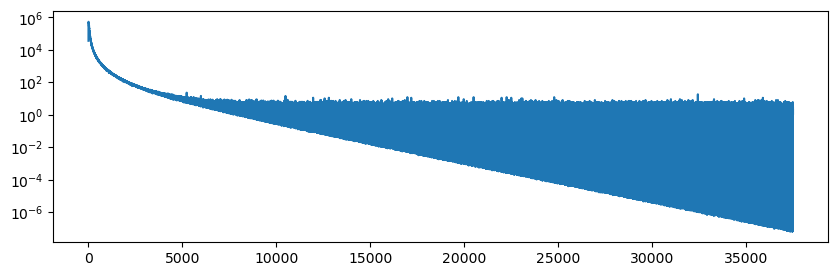

In [5]:
plt.figure(figsize=(10,3))
plt.plot(losses)
plt.yscale('log')

In [9]:
print(len(sampled_appearances))
np_sampled_appearances = np.array(sampled_appearances, dtype=object)
sorted_appearances = sorted(np_sampled_appearances, key=lambda x: x[1], reverse=True)
top_10_appearances = sorted_appearances[:30]

print("Top 10 appearances with highest rewards:")
for i, (appearance, reward) in enumerate(top_10_appearances, 1):
    # print(f"{i}. Appearance: {appearance}, Reward: {reward}")
    print(f"{draw_appearance(appearance)}, Reward: {reward}")



# sample_size = 50000
# valid_ratio = sum([appearance_reward(i[0]) > 0 for i in sampled_appearances[-sample_size:]]) / sample_size
# reward_1_ratio = sum([appearance_reward(i[0]) == 1 for i in sampled_appearances[-sample_size:]]) / sample_size
# reward_3_ratio = sum([appearance_reward(i[0]) == 3 for i in sampled_appearances[-sample_size:]]) / sample_size

# print('Ratio of valid appearances:', valid_ratio)
# print('Ratio of appearances with reward 1:', reward_1_ratio)
# print('Ratio of appearances with reward 3:', reward_3_ratio)


600000
Top 10 appearances with highest rewards:
[0, -3, 4, 0, 0, -4, -7, 4, 7], Reward: 4
[4, 3, -7, -3, 3, -1, 3, -6, 0], Reward: 4
[4, 4, -5, -4, 2, 0, 3, -4, 0], Reward: 3
[4, 0, -4, -6, 0, 3, 0, -4, 4], Reward: 3
[3, -4, 0, 0, 3, -6, -5, 1, 0], Reward: 3
[0, -7, 5, 3, 0, -4, -5, 0, 4], Reward: 3
[2, -4, 0, 0, 3, -4, -4, 3, 3], Reward: 3
[0, -4, 5, 0, 5, -6, -3, 0, 3], Reward: 3
[3, 1, -9, -4, 4, 0, 0, -6, 0], Reward: 3
[0, 4, -4, -7, 7, 0, 0, 0, 0], Reward: 3
[3, 0, -4, -6, 5, 0, 3, -3, 0], Reward: 3
[0, 3, -2, -6, 4, 4, 0, -4, 3], Reward: 3
[3, -4, 1, 0, 3, -6, -4, 0, 0], Reward: 3
[3, 5, -7, -3, 3, 0, 0, -2, 3], Reward: 3
[7, 0, -7, 0, 4, -2, 4, -2, 0], Reward: 3
[3, -4, 0, 2, 3, -4, -4, 3, 3], Reward: 3
[5, -4, 4, 0, 4, -2, -4, 1, 3], Reward: 3
[5, 4, -4, -4, 3, 0, 2, 0, 2], Reward: 3
[3, 0, -4, -7, 5, 0, 1, -9, 0], Reward: 3
[3, 0, -6, -4, 1, 2, 1, -6, 1], Reward: 3
[0, -3, 5, -1, 3, -2, -7, 0, 7], Reward: 3
[3, 0, -5, -4, 0, 2, 0, -9, 5], Reward: 3
[4, -4, 0, 4, 2, -5, -2, 0, 

# one trajectory 

In [7]:

def sample_trajectory(F_sa, sorted_keys, n_steps=10):
    state = []  # Start with an empty state
    trajectory = []

    for t in range(n_steps):
        edge_flow_prediction = F_sa(appearance_to_tensor(state))
        policy = edge_flow_prediction / edge_flow_prediction.sum()
        action = Categorical(probs=policy).sample().item()
        new_state = state + [sorted_keys[action]]
        trajectory.append(new_state)
        
        if sorted_keys[action] == 'stop':
            break
        state = new_state
        
    return trajectory


F_sa = FlowModel()
# Example usage
trajectory = sample_trajectory(F_sa, sorted_keys)
print("Sampled trajectory:", trajectory)
for appearance in trajectory:
    print(f"Appearance: {draw_appearance(appearance)}, Reward: {appearance_reward(appearance)}")


Sampled trajectory: [['w8_plus4'], ['w8_plus4', 'w2_minus1'], ['w8_plus4', 'w2_minus1', 'w3_minus4'], ['w8_plus4', 'w2_minus1', 'w3_minus4', 'w1_plus1'], ['w8_plus4', 'w2_minus1', 'w3_minus4', 'w1_plus1', 'w0_minus2'], ['w8_plus4', 'w2_minus1', 'w3_minus4', 'w1_plus1', 'w0_minus2', 'w7_plus3'], ['w8_plus4', 'w2_minus1', 'w3_minus4', 'w1_plus1', 'w0_minus2', 'w7_plus3', 'w0_minus1'], ['w8_plus4', 'w2_minus1', 'w3_minus4', 'w1_plus1', 'w0_minus2', 'w7_plus3', 'w0_minus1', 'w5_minus1'], ['w8_plus4', 'w2_minus1', 'w3_minus4', 'w1_plus1', 'w0_minus2', 'w7_plus3', 'w0_minus1', 'w5_minus1', 'w0_plus4'], ['w8_plus4', 'w2_minus1', 'w3_minus4', 'w1_plus1', 'w0_minus2', 'w7_plus3', 'w0_minus1', 'w5_minus1', 'w0_plus4', 'w0_plus3']]
Appearance: [0, 0, 0, 0, 0, 0, 0, 0, 4], Reward: 0
Appearance: [0, 0, -1, 0, 0, 0, 0, 0, 4], Reward: 0
Appearance: [0, 0, -1, -4, 0, 0, 0, 0, 4], Reward: 0
Appearance: [0, 1, -1, -4, 0, 0, 0, 0, 4], Reward: 0
Appearance: [-2, 1, -1, -4, 0, 0, 0, 0, 4], Reward: 0
Appear

In [8]:
def sample_trajectory_until_reward(F_sa, sorted_keys, target_reward, max_attempts=5000000):
    for attempt in range(max_attempts):
        trajectory = sample_trajectory(F_sa, sorted_keys)
        final_appearance = trajectory[-1]
        reward = appearance_reward(final_appearance)
        # print(f"Attempt {attempt + 1}: Reward = {reward}")
        
        if reward == target_reward:
            print(f"Found reward {target_reward} after {attempt + 1} attempts!")
            return trajectory, reward
    
    print(f"Failed to find reward {target_reward} after {max_attempts} attempts.")
    return None, None

# # Sample trajectories until we find one with reward 3
# trajectory, reward = sample_trajectory_until_reward_3(F_sa, sorted_keys)

# if trajectory:
#     print("Successful trajectory:")
#     for appearance in trajectory:
#         print(f"Appearance: {draw_appearance(appearance)}, Reward: {appearance_reward(appearance)}")
# else:
#     print("No trajectory with reward 3 found.")


In [15]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.integrate import odeint

# def plot_dynamical_system(coord, ndim, title):
#     matrix_dim = int(np.sqrt(ndim))
#     xinit = np.linspace(0, 1, matrix_dim, endpoint=False)  # Initial conditions
#     t = np.linspace(0, 20, 200)  # Define the time points
    
#     sol = odeint(node_system_with_sigmoid, xinit, t, args=(coord,))
    
#     plt.figure(figsize=(8, 6))
#     for i in range(matrix_dim):
#         plt.plot(t, sol[:, i], label=f'x{i+1}')
    
#     plt.xlabel('Time')
#     plt.ylabel('State')
#     plt.title(title)
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# # Plot each appearance and its reward from start to finish
# if trajectory:
#     for i, appearance in enumerate(trajectory):
#         coord = np.array(draw_appearance(appearance)) 
#         ndim = len(coord)
#         current_reward = appearance_reward(appearance)
        
#         plot_dynamical_system(coord, ndim, f"Appearance {i+1}: Reward {current_reward}")
# else:
#     print("No trajectory to plot.")
    
    




In [16]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.integrate import odeint
# import imageio

# def plot_dynamical_system(coord, ndim):
#     matrix_dim = int(np.sqrt(ndim))
#     xinit = np.linspace(0, 1, matrix_dim, endpoint=False)  # Initial conditions
#     t = np.linspace(0, 20, 200)  # Define the time points
    
#     sol = odeint(node_system_with_sigmoid, xinit, t, args=(coord,))
#     return t, sol

# def create_frames(trajectory):
#     frames = []
#     for frame, appearance in enumerate(trajectory):
#         fig, ax = plt.subplots(figsize=(8, 6))
#         coord = np.array(draw_appearance(appearance)) 
#         ndim = len(coord)
#         t, sol = plot_dynamical_system(coord, ndim)
        
#         for i in range(len(sol[0])):
#             ax.plot(t, sol[:, i], label=f'x{i+1}')
        
#         ax.set_xlabel('Time')
#         ax.set_ylabel('State')
#         ax.set_title(f"Appearance {frame+1}: Reward {appearance_reward(appearance)}")
#         ax.legend()
#         ax.grid(True)
        
#         # Save the current frame
#         fig.canvas.draw()
#         image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#         image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#         frames.append(image)
#         plt.close(fig)
#     return frames

# # Create the frames
# if trajectory:
#     frames = create_frames(trajectory)
#     # Save as an MP4 file
#     imageio.mimsave('dynamical_system.mp4', frames, fps=2)
# else:
#     print("No trajectory to plot.")

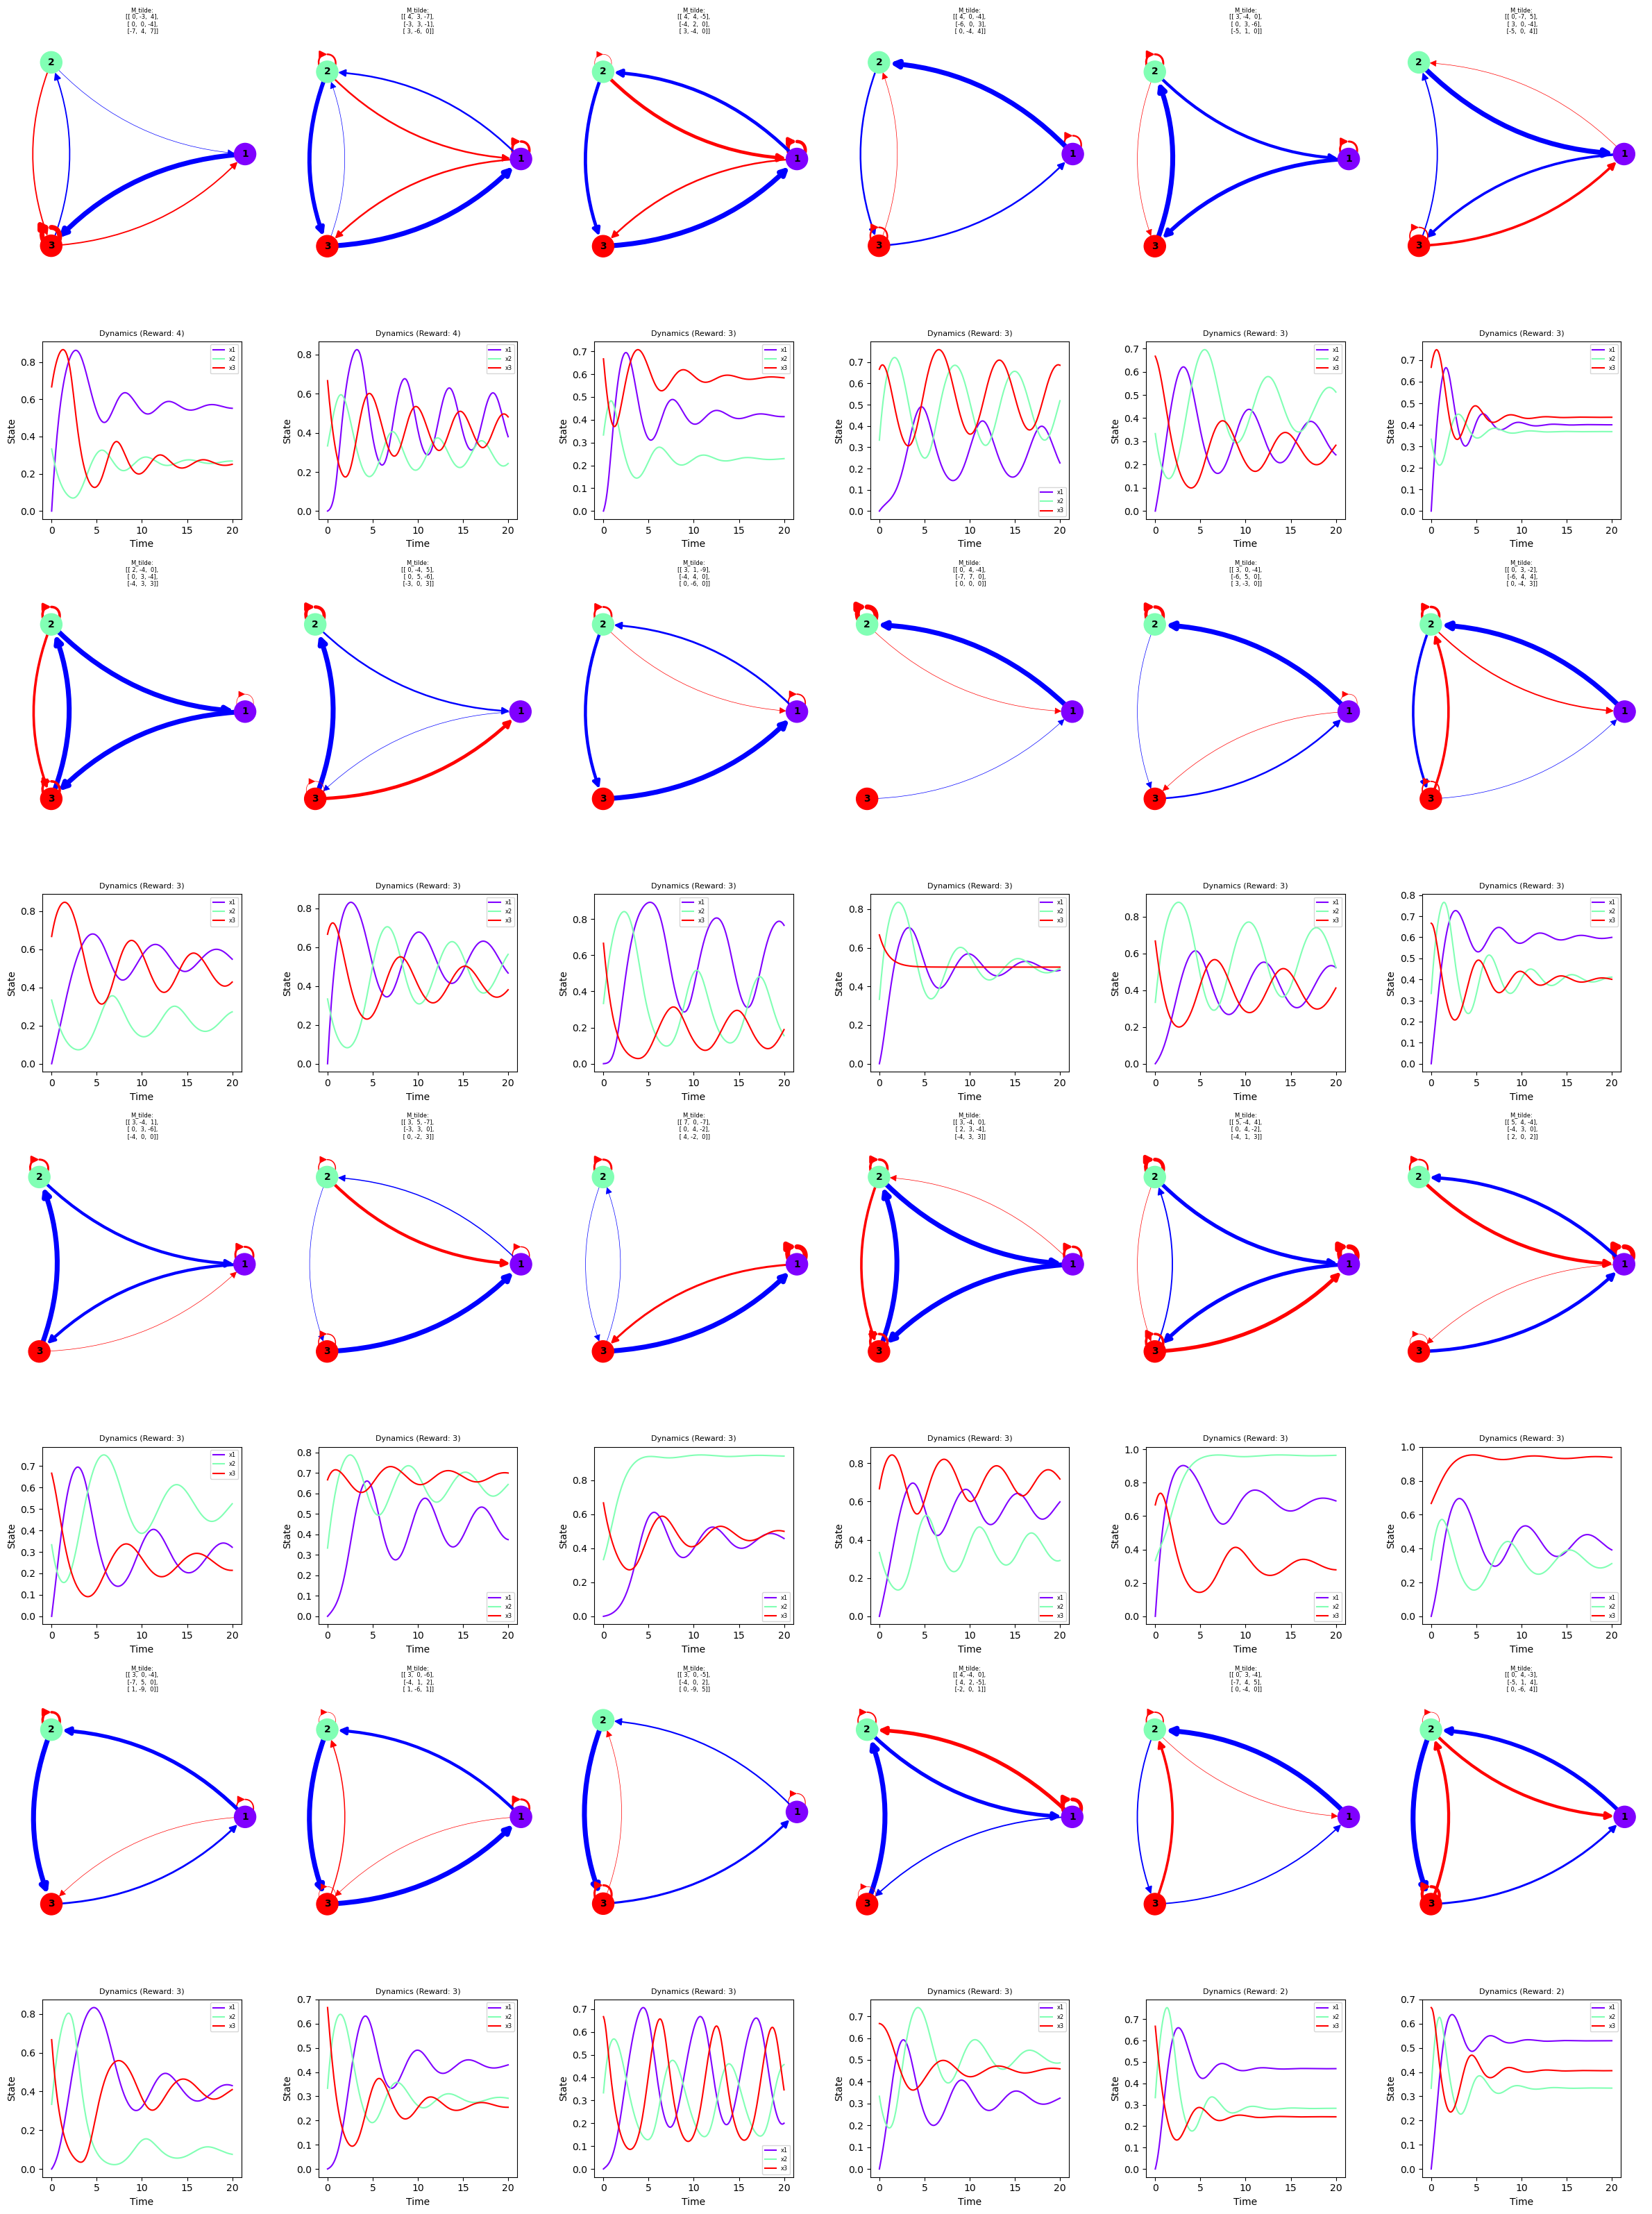

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def node_system_with_sigmoid(x, t, coord):
    matrix_dim = len(x)
    M_tilde = np.reshape(coord, (matrix_dim, matrix_dim))
    z = M_tilde.dot(x)
    sigmoid_z = sigmoid(z)
    dxdt = sigmoid_z - x
    return dxdt

def reward_oscillator(coord, ndim):
    delta = 0.0001
    matrix_dim = int(np.sqrt(ndim))
    xinit = np.linspace(0, 1, matrix_dim, endpoint=False)
    t = np.linspace(0, 20, 200)
    sol = odeint(node_system_with_sigmoid, xinit, t, args=(coord,))
    
    x1 = sol[:, 0]
    dx1 = np.diff(x1)
    x1_peaks = 0
    for j in range(1, len(dx1)):
        if dx1[j-1] > 0 and dx1[j] < 0:
            sharpness = x1[j] - (x1[j-1] + x1[j+1]) / 2
            if sharpness > delta:
                x1_peaks += 1
    
    return x1_peaks if x1_peaks > 0 else 0



def draw_network_motif(num_nodes, weights, reward, ax):
    weight_matrix = np.array(weights).reshape(num_nodes, num_nodes)
    
    G = nx.DiGraph()
    node_colors = plt.cm.rainbow(np.linspace(0, 1, num_nodes))
    
    G.add_nodes_from(range(1, num_nodes + 1))
    
    edge_colors_dict = {}
    edge_widths_dict = {}
    for i in range(num_nodes):
        for j in range(num_nodes):
            if weight_matrix[i, j] != 0:
                edge = (j + 1, i + 1)
                G.add_edge(*edge, weight=weight_matrix[i, j])
                edge_colors_dict[edge] = 'blue' if weight_matrix[i, j] < 0 else 'red'
                edge_widths_dict[edge] = abs(weight_matrix[i, j])
    
    edge_colors = [edge_colors_dict[edge] for edge in G.edges]
    edge_widths = [edge_widths_dict[edge] for edge in G.edges]
    
    if edge_widths:
        min_width = min(edge_widths)
        max_width = max(edge_widths)
        if min_width != max_width:
            edge_widths = [0.1 + 5 * ((width - min_width) / (max_width - min_width)) for width in edge_widths]
        edge_widths = [max(width, 0.5) for width in edge_widths]  # Ensure minimum visibility
    
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax, with_labels=True, node_size=NODE_SIZE, node_color=node_colors, font_size=10, font_weight='bold', 
            arrows=True, arrowsize=15, edge_color=edge_colors, width=edge_widths, connectionstyle="arc3,rad=0.2")

def plot_dynamical_system(weights, ax):
    ndim = len(weights)
    matrix_dim = int(np.sqrt(ndim))
    x0 = np.linspace(0, 1, matrix_dim, endpoint=False)
    t = np.linspace(0, 20, 200)
    sol = odeint(node_system_with_sigmoid, x0, t, args=(weights,))
    
    node_colors = plt.cm.rainbow(np.linspace(0, 1, matrix_dim))
    for i in range(matrix_dim):
        ax.plot(t, sol[:, i], label=f'x{i+1}', color=node_colors[i])
    
    ax.set_xlabel('Time')
    ax.set_ylabel('State')
    ax.legend(fontsize=DYNAMICS_LEGEND_FONT_SIZE)


        
def plot_motif_and_dynamics(weights_list):
    motifs_per_row = MOTIF_PER_ROW
    num_nodes = int(np.sqrt(len(weights_list[0])))
    num_motifs = len(weights_list)
    num_rows = (num_motifs + motifs_per_row - 1) // motifs_per_row
    fig, axs = plt.subplots(2 * num_rows, motifs_per_row, figsize=(PLOT_WIDTH_PER_MOTIF * motifs_per_row, PLOT_HEIGHT * num_rows))
    
    for i, weights in enumerate(weights_list):
        row = (i // motifs_per_row) * 2
        col = i % motifs_per_row
        
        ndim = len(weights)
        matrix_dim = int(np.sqrt(ndim))
        M_tilde = np.reshape(weights, (matrix_dim, matrix_dim))
        reward = reward_oscillator(weights, ndim)
        
        # Plot network motif
        draw_network_motif(num_nodes, weights, reward, axs[row, col])
        
        # Add M_tilde as text above the motif plot
        M_tilde_str = np.array2string(M_tilde, separator=', ', prefix='', suffix='')
        axs[row, col].text(0.5, 1.1, f"M_tilde:\n{M_tilde_str}", 
                    horizontalalignment='center', verticalalignment='center', 
                    transform=axs[row, col].transAxes, fontsize=MOTIF_TEXT_FONT_SIZE, wrap=True)
        
        # Plot dynamical system
        dynamics_ax = axs[row+1, col].inset_axes([0.1, 0.1, 0.8, 0.8])  # Create a smaller, centered subplot
        plot_dynamical_system(weights, dynamics_ax)
        dynamics_ax.set_title(f'Dynamics (Reward: {reward})', fontsize=DYNAMICS_TITLE_FONT_SIZE)
        axs[row+1, col].axis('off')  # Turn off the outer axes

    # Remove unused subplots
    for i in range(num_motifs, num_rows * motifs_per_row):
        row = (i // motifs_per_row) * 2
        col = i % motifs_per_row
        fig.delaxes(axs[row, col])
        fig.delaxes(axs[row+1, col])

    plt.tight_layout()
    plt.show()



# Example weights list
weights_list = [
[0, -3, 4, 0, 0, -4, -7, 4, 7], 
[4, 3, -7, -3, 3, -1, 3, -6, 0], 
[4, 4, -5, -4, 2, 0, 3, -4, 0], 
[4, 0, -4, -6, 0, 3, 0, -4, 4], 
[3, -4, 0, 0, 3, -6, -5, 1, 0], 
[0, -7, 5, 3, 0, -4, -5, 0, 4], 
[2, -4, 0, 0, 3, -4, -4, 3, 3], 
[0, -4, 5, 0, 5, -6, -3, 0, 3], 
[3, 1, -9, -4, 4, 0, 0, -6, 0], 
[0, 4, -4, -7, 7, 0, 0, 0, 0], 
[3, 0, -4, -6, 5, 0, 3, -3, 0], 
[0, 3, -2, -6, 4, 4, 0, -4, 3], 
[3, -4, 1, 0, 3, -6, -4, 0, 0], 
[3, 5, -7, -3, 3, 0, 0, -2, 3], 
[7, 0, -7, 0, 4, -2, 4, -2, 0], 
[3, -4, 0, 2, 3, -4, -4, 3, 3], 
[5, -4, 4, 0, 4, -2, -4, 1, 3], 
[5, 4, -4, -4, 3, 0, 2, 0, 2], 
[3, 0, -4, -7, 5, 0, 1, -9, 0], 
[3, 0, -6, -4, 1, 2, 1, -6, 1], 
[3, 0, -5, -4, 0, 2, 0, -9, 5], 
[4, -4, 0, 4, 2, -5, -2, 0, 1], 
[0, 3, -4, -7, 4, 5, 0, -4, 0], 
[0, 4, -3, -5, 1, 4, 0, -6, 4], 
]

# Plot configuration parameters
MOTIF_PER_ROW = 6
PLOT_HEIGHT = 8
PLOT_WIDTH_PER_MOTIF = 4
MOTIF_TEXT_FONT_SIZE = 6
DYNAMICS_TITLE_FONT_SIZE = 8
DYNAMICS_LEGEND_FONT_SIZE = 6
NODE_SIZE = 500
 
# Plot motifs and dynamics
plot_motif_and_dynamics(weights_list)



In [14]:
# Load successful trajectories from the pickle file
with open("successful_trajectories_3nodes_360found_reward3.pkl", "rb") as f:
    successful_trajectories = pickle.load(f)

# Print the length of successful_trajectories
print(f"Number of successful trajectories: {len(successful_trajectories)}")

Number of successful trajectories: 360


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import imageio
    

def create_frames(trajectory):
    frames = []
    for frame, appearance in enumerate(trajectory):
        fig, (ax_dynamics, ax_motif) = plt.subplots(2, 1, figsize=(6, 10))
        ax_dynamics.set_xlabel('Time')
        ax_dynamics.set_ylabel('State')
        ax_dynamics.set_title(f"Appearance {frame+1}: Reward {appearance_reward(appearance)}")
        ax_dynamics.legend()
        ax_dynamics.grid(True)      
        weights = np.array(draw_appearance(appearance)) 
        reward = appearance_reward(appearance)
        # Plot dynamics
        plot_dynamical_system(weights, ax_dynamics)
        # Plot motif
        draw_network_motif(n_node, weights, reward, ax_motif)
        
        # Save the current frame
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
        plt.close(fig)
    return frames

# Create the frames
if successful_trajectories[100]:
    frames = create_frames(successful_trajectories[100])
    # Save as an MP4 file
    imageio.mimsave('dynamical_system_with_motif.mp4', frames, fps=1)
else:
    print("No trajectory to plot.")

/tmp/ipykernel_1202111/1593518909.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_dynamics.legend()
/tmp/ipykernel_1202111/1593518909.py:25: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 1000) to (608, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6fb22c0] Warning: data is not aligned! This can lead to a speed loss


# Multi-trajectory Analysis










In [19]:
# Sample multiple trajectories with reward 3
num_trajectories = 500
successful_trajectories = []

for i in range(num_trajectories):
    trajectory, reward = sample_trajectory_until_reward(F_sa, sorted_keys, 3)
    if trajectory:
        successful_trajectories.append(trajectory)
        print(f"Found trajectory {len(successful_trajectories)} of {num_trajectories} (Progress: {len(successful_trajectories)/num_trajectories*100:.2f}%)")
        # Save to file every 10 found trajectories
        if len(successful_trajectories) % 10 == 0:
            filename = f"successful_trajectories_{n_node}nodes_reward3.pkl"
            with open(filename, "wb") as f:
                pickle.dump(successful_trajectories, f)
            print(f"Saved {len(successful_trajectories)} successful trajectories to {filename}")

print(f"Successfully sampled {len(successful_trajectories)} trajectories with reward 3 (Final success rate: {len(successful_trajectories)/num_trajectories*100:.2f}%)")


Found reward 3 after 33446 attempts!
Found trajectory 1 of 500 (Progress: 0.20%)
Found reward 3 after 6990 attempts!
Found trajectory 2 of 500 (Progress: 0.40%)
Found reward 3 after 40618 attempts!
Found trajectory 3 of 500 (Progress: 0.60%)
Found reward 3 after 635 attempts!
Found trajectory 4 of 500 (Progress: 0.80%)
Found reward 3 after 22532 attempts!
Found trajectory 5 of 500 (Progress: 1.00%)
Found reward 3 after 11698 attempts!
Found trajectory 6 of 500 (Progress: 1.20%)
Found reward 3 after 14722 attempts!
Found trajectory 7 of 500 (Progress: 1.40%)
Found reward 3 after 25102 attempts!
Found trajectory 8 of 500 (Progress: 1.60%)
Found reward 3 after 99159 attempts!
Found trajectory 9 of 500 (Progress: 1.80%)
Found reward 3 after 19548 attempts!
Found trajectory 10 of 500 (Progress: 2.00%)
Saved 10 successful trajectories to successful_trajectories_3nodes_10found_reward3.pkl
Found reward 3 after 375 attempts!
Found trajectory 11 of 500 (Progress: 2.20%)
Found reward 3 after 2661

In [11]:
# Load successful trajectories from the pickle file
with open("successful_trajectories_3nodes_360found_reward3.pkl", "rb") as f:
    successful_trajectories = pickle.load(f)

# Print the length of successful_trajectories
print(f"Number of successful trajectories: {len(successful_trajectories)}")

Number of successful trajectories: 360


In [24]:
# Assuming successful_trajectories[0] is already defined
trajectory = successful_trajectories[0]

# Convert each appearance in the trajectory to weights
trajectory_weights = [draw_appearance(appearance) for appearance in trajectory]

# Print the weights for each appearance
for i, weights in enumerate(trajectory_weights):
    print(f"Appearance {i+1}: {weights}")

Appearance 1: [0, 0, 0, 0, 0, -1, 0, 0, 0]
Appearance 2: [0, 0, 0, -4, 0, -1, 0, 0, 0]
Appearance 3: [0, 0, 0, -4, 0, -1, 0, -4, 0]
Appearance 4: [4, 0, 0, -4, 0, -1, 0, -4, 0]
Appearance 5: [4, 0, 0, -4, 0, -1, 4, -4, 0]
Appearance 6: [5, 0, 0, -4, 0, -1, 4, -4, 0]
Appearance 7: [5, 0, -2, -4, 0, -1, 4, -4, 0]
Appearance 8: [5, 0, -6, -4, 0, -1, 4, -4, 0]
Appearance 9: [5, 0, -6, -4, 0, 1, 4, -4, 0]
Appearance 10: [5, 3, -6, -4, 0, 1, 4, -4, 0]


In [28]:
# Assuming successful_trajectories is already defined
weights_trajectories = []

# Define the zero vector based on the number of weights (n_w)
zero_vector = [0] * n_w

for trajectory in successful_trajectories:
    # Convert each appearance in the trajectory to weights
    weights_trajectory = [draw_appearance(appearance) for appearance in trajectory]
    # Prepend the zero vector to ensure the trajectory starts from zero
    weights_trajectory.insert(0, zero_vector)
    weights_trajectories.append(weights_trajectory)

# Print the weights for each trajectory
for i, weights_trajectory in enumerate(weights_trajectories):
    print(f"Trajectory {i+1}:")
    for j, weights in enumerate(weights_trajectory):
        print(f"  Appearance {j+1}: {weights}")

Trajectory 1:
  Appearance 1: [0, 0, 0, 0, 0, 0, 0, 0, 0]
  Appearance 2: [0, 0, 0, 0, 0, -1, 0, 0, 0]
  Appearance 3: [0, 0, 0, -4, 0, -1, 0, 0, 0]
  Appearance 4: [0, 0, 0, -4, 0, -1, 0, -4, 0]
  Appearance 5: [4, 0, 0, -4, 0, -1, 0, -4, 0]
  Appearance 6: [4, 0, 0, -4, 0, -1, 4, -4, 0]
  Appearance 7: [5, 0, 0, -4, 0, -1, 4, -4, 0]
  Appearance 8: [5, 0, -2, -4, 0, -1, 4, -4, 0]
  Appearance 9: [5, 0, -6, -4, 0, -1, 4, -4, 0]
  Appearance 10: [5, 0, -6, -4, 0, 1, 4, -4, 0]
  Appearance 11: [5, 3, -6, -4, 0, 1, 4, -4, 0]
Trajectory 2:
  Appearance 1: [0, 0, 0, 0, 0, 0, 0, 0, 0]
  Appearance 2: [0, 0, 0, 0, 3, 0, 0, 0, 0]
  Appearance 3: [0, 0, 0, 0, 2, 0, 0, 0, 0]
  Appearance 4: [0, 3, 0, 0, 2, 0, 0, 0, 0]
  Appearance 5: [4, 3, 0, 0, 2, 0, 0, 0, 0]
  Appearance 6: [4, 3, -1, 0, 2, 0, 0, 0, 0]
  Appearance 7: [4, 3, -1, -3, 2, 0, 0, 0, 0]
  Appearance 8: [4, 3, -1, -4, 2, 0, 0, 0, 0]
  Appearance 9: [4, 3, -1, -4, 2, 0, 0, 0, 3]
  Appearance 10: [4, 3, -1, -4, 4, 0, 0, 0, 3]
  Appea

In [36]:
# Get the shape of weights_trajectories
print(len(weights_trajectories))
print(len(weights_trajectories[0]))
# note that each trajectory has a different length (not 11).


360
11


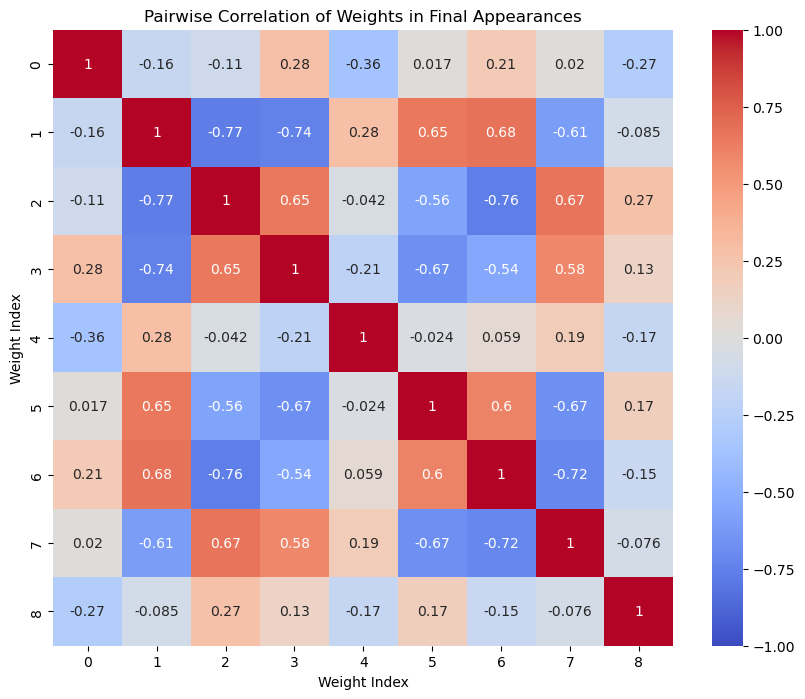

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the last matrix from each trajectory
last_matrices = [trajectory[-1] for trajectory in weights_trajectories]

# Convert to numpy array
last_matrices_array = np.array(last_matrices)

# Compute pairwise correlations
correlation_matrix = np.corrcoef(last_matrices_array.T)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlation of Weights in Final Appearances')
plt.xlabel('Weight Index')
plt.ylabel('Weight Index')
plt.show()


# CORE

In [78]:
#core trajectory intersection
import numpy as np

# Count occurrences of each matrix
matrix_counts = {}
for trajectory in weights_trajectories:
    for matrix in trajectory:
        matrix_str = str(matrix)  # Convert matrix to string for comparison
        if matrix_str in matrix_counts:
            matrix_counts[matrix_str] += 1
        else:
            matrix_counts[matrix_str] = 1

# Get the top 10 most common matrices
top_80_matrices = sorted(matrix_counts.items(), key=lambda x: x[1], reverse=True)[:80]

print("Top 80 most common intersection matrices:")
for i, (matrix_str, count) in enumerate(top_80_matrices, 1):
    print(f"\nRank {i}: Visited {count} times")
    print(np.array(eval(matrix_str)))  # Convert string back to numpy array for printing

Top 80 most common intersection matrices:

Rank 1: Visited 362 times
[0 0 0 0 0 0 0 0 0]

Rank 2: Visited 19 times
[4 0 0 0 0 0 0 0 0]

Rank 3: Visited 16 times
[0 0 0 0 3 0 0 0 0]

Rank 4: Visited 16 times
[ 0  0  0  0  0 -4  0  0  0]

Rank 5: Visited 12 times
[2 0 0 0 0 0 0 0 0]

Rank 6: Visited 12 times
[ 0  0  0  0  0  0  0 -4  0]

Rank 7: Visited 12 times
[ 0  0  0  0  0  0 -3  0  0]

Rank 8: Visited 12 times
[0 0 0 0 0 0 0 0 4]

Rank 9: Visited 11 times
[0 0 0 0 4 0 0 0 0]

Rank 10: Visited 10 times
[ 0  0  0  0  0 -1  0  0  0]

Rank 11: Visited 10 times
[ 0  0  0  0  0  0 -4  0  0]

Rank 12: Visited 10 times
[ 0 -3  0  0  0  0  0  0  0]

Rank 13: Visited 10 times
[0 0 0 0 0 0 0 0 3]

Rank 14: Visited 10 times
[ 0  0  0  0  0  0  0 -3  0]

Rank 15: Visited 9 times
[0 0 0 0 2 0 0 0 0]

Rank 16: Visited 9 times
[ 0  0  0 -3  0  0  0  0  0]

Rank 17: Visited 9 times
[ 0  0 -4  0  0  0  0  0  0]

Rank 18: Visited 8 times
[0 0 0 0 0 0 0 0 1]

Rank 19: Visited 8 times
[ 0 -4  0  0  0  

In [77]:
len(matrix_counts)


3175

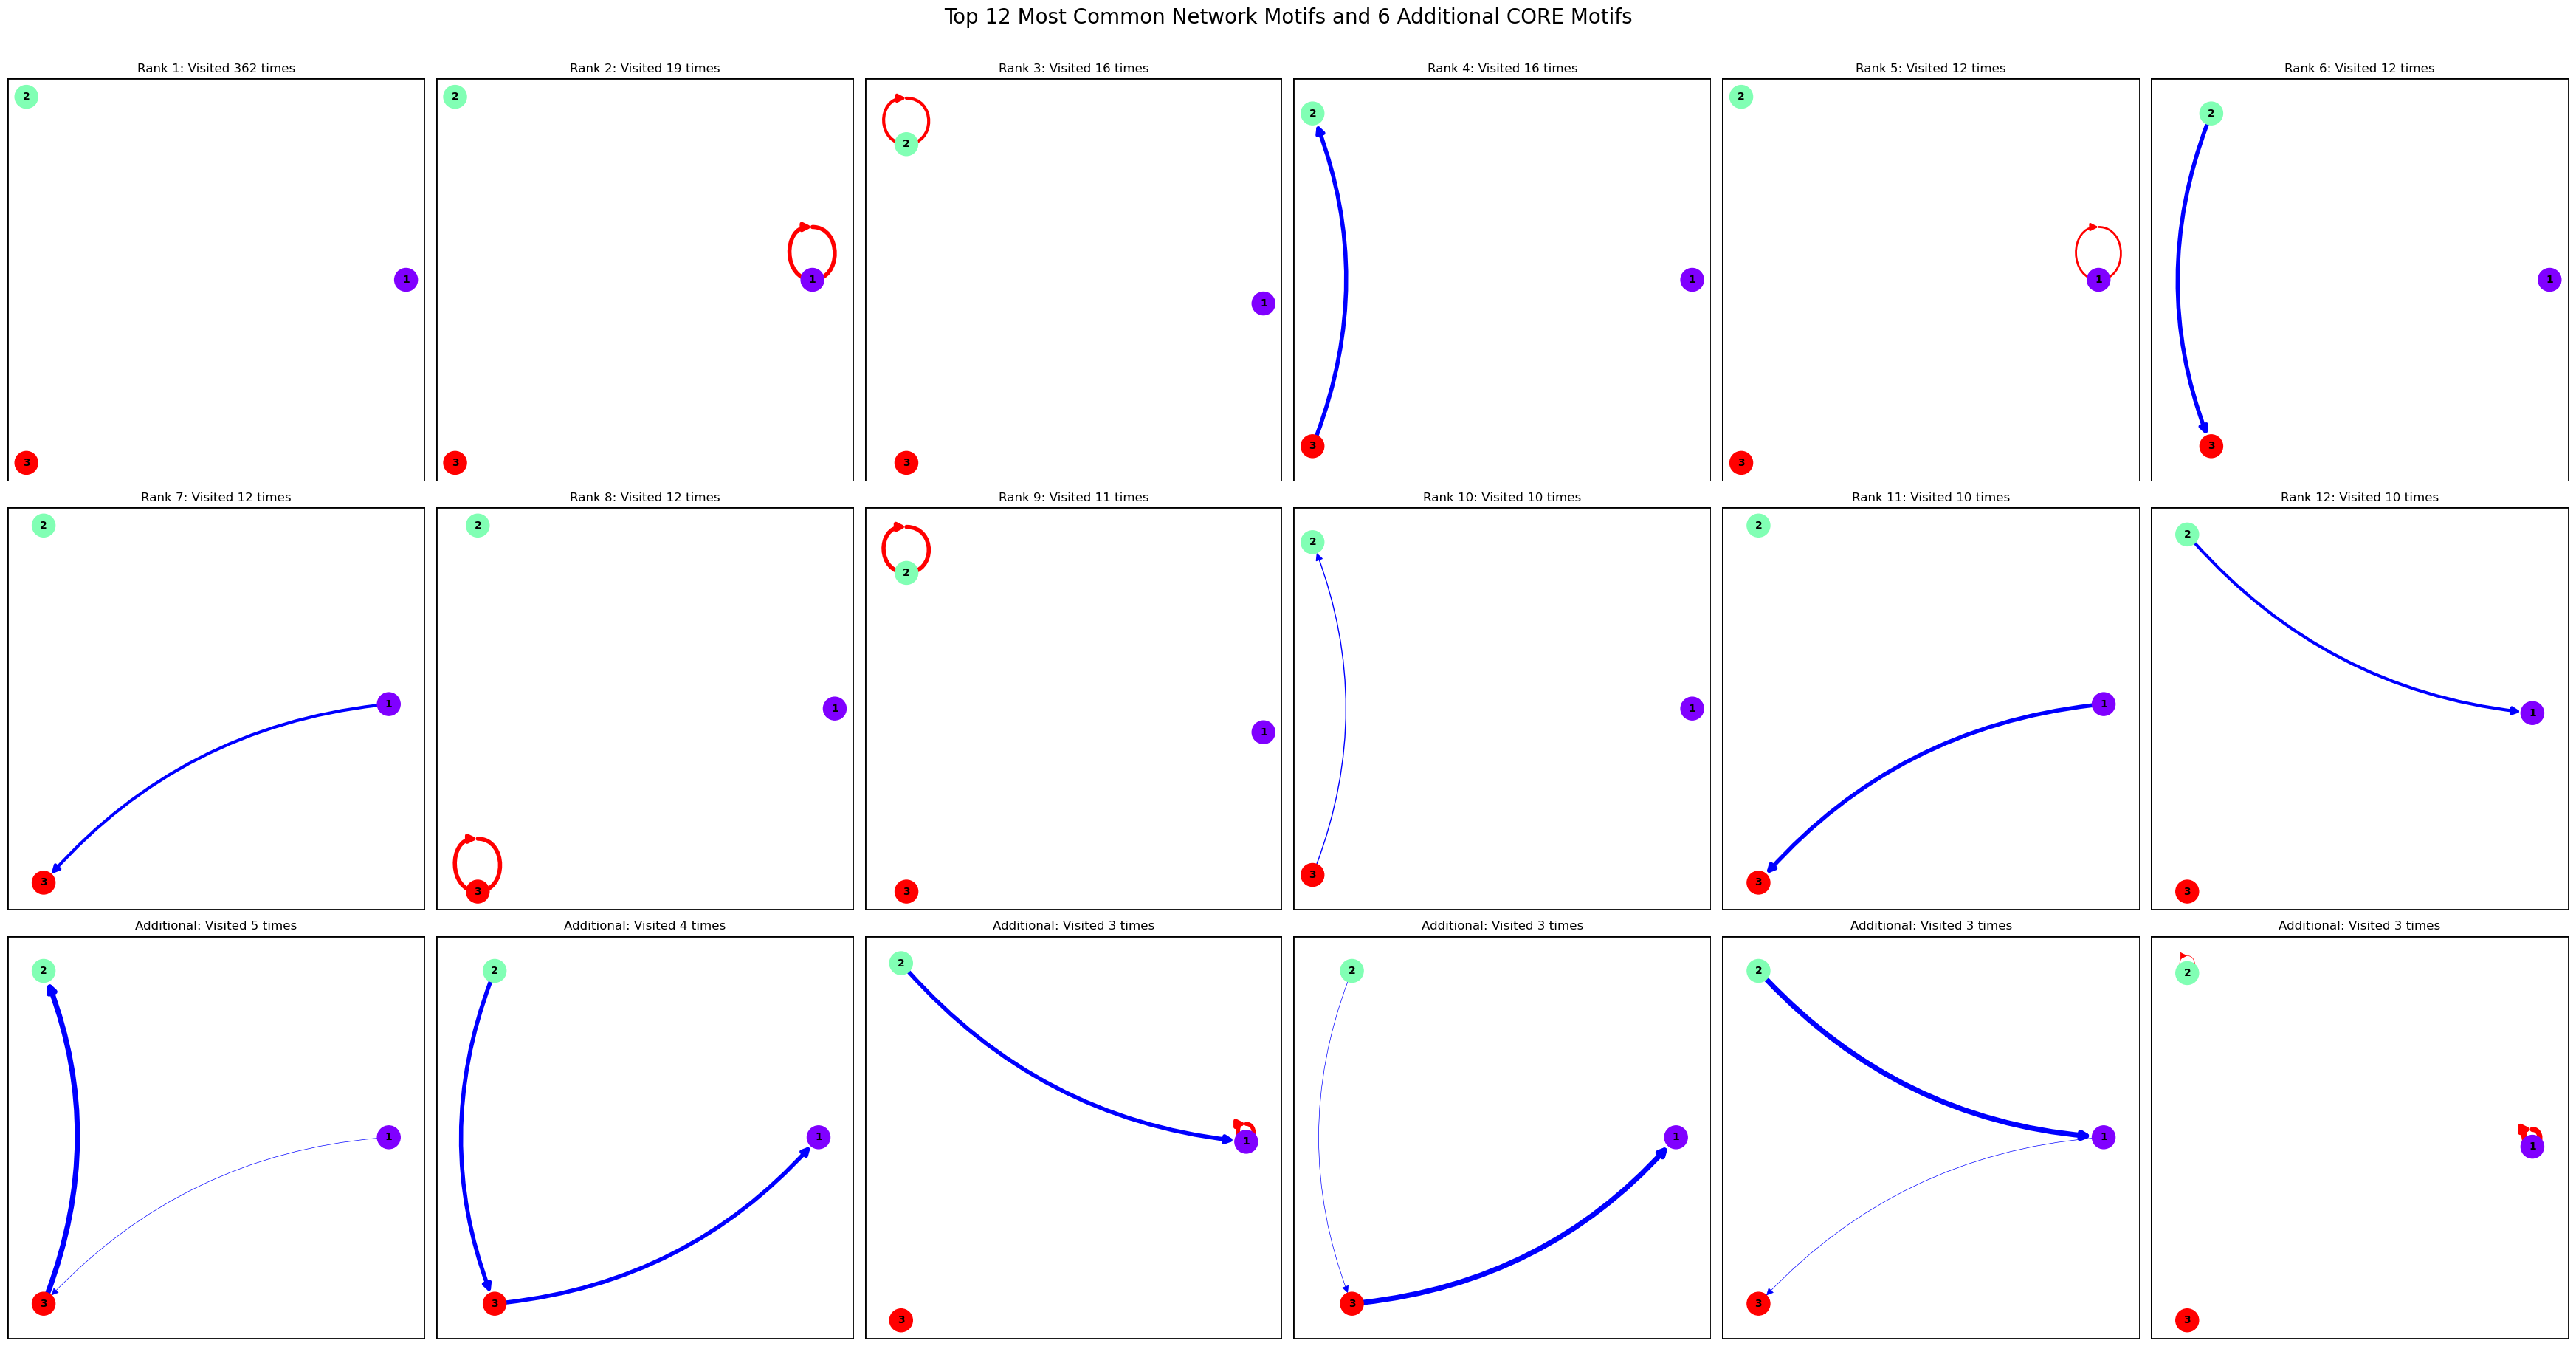

In [83]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

top_12_matrices = sorted(matrix_counts.items(), key=lambda x: x[1], reverse=True)[:12]
additional_matrices = [
    (str([0, 0, 0, 0, 0, -4, -3, 0, 0]), 5),
    (str([0, 0, -4, 0, 0, 0, 0, -4, 0]), 4),
    (str([4, -4, 0, 0, 0, 0, 0, 0, 0]), 3),
    (str([0, 0, -4, 0, 0, 0, 0, -3, 0]), 3),
    (str([0, -4, 0, 0, 0, 0, -2, 0, 0]), 3),
    (str([4, 0, 0, 0, 3, 0, 0, 0, 0]), 3)
]

fig, axes = plt.subplots(3, 6, figsize=(35, 18))  # Adjusted figure size for 3 rows
fig.suptitle('Top 12 Most Common Network Motifs and 6 Additional CORE Motifs', fontsize=20, y=1.01)  # Increased y value for higher spacing

all_matrices = top_12_matrices + additional_matrices

for i, (matrix_str, count) in enumerate(all_matrices):
    ax = axes[i // 6, i % 6]
    weights = eval(matrix_str)
    draw_network_motif(3, weights, count, ax)
    
    if i < 12:
        ax.set_title(f"Rank {i+1}: Visited {count} times")
    else:
        ax.set_title(f"Additional: Visited {count} times")
    
    # Add a rectangle around each subplot
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                     color='black', fill=False, linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

# PHATE


In [84]:
import numpy as np

# ensure that each trajectory has a uniform length of 11.
zero_vector = [0] * 9
padded_trajectories = [
    ([zero_vector] * (11 - len(trajectory)) + trajectory)[:11]
    for trajectory in weights_trajectories
]

weights_trajectories_array = np.array(padded_trajectories, dtype=float).reshape(360, 11, 9)
weights_trajectories_flat = weights_trajectories_array.reshape(360 * 11, 9)
print(weights_trajectories_flat.shape)

# Create an index array that increases over the second index from 0 to 10
# The first index is uniform and of size 360
index_array = np.repeat(np.arange(11)[np.newaxis, :], 360, axis=0)

# Flatten the index array
index_array_flat = index_array.flatten()



In [2]:
import phate
import numpy as np

reducer = phate.PHATE(knn=300, n_jobs=-1, verbose=True, n_components=2)
embed = reducer.fit_transform(weights_trajectories_flat)
print(embed.shape)


NameError: name 'weights_trajectories_flat' is not defined

In [1]:
phate.cluster.kmeans(embed, n_clusters=10)

NameError: name 'phate' is not defined

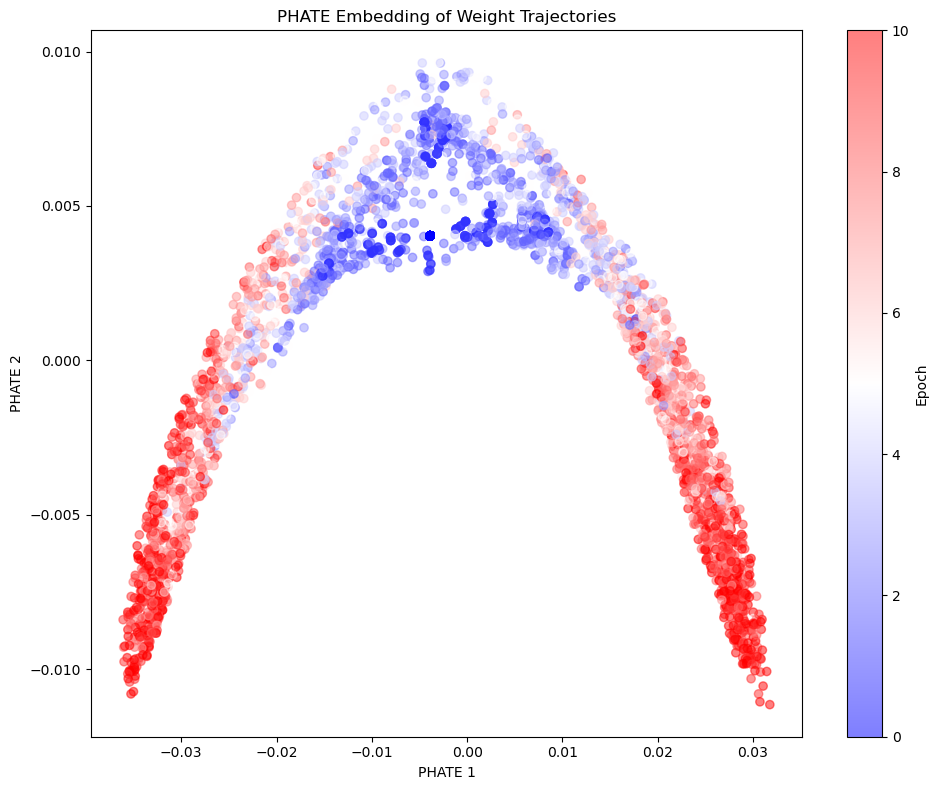

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embed[:, 0], embed[:, 1], alpha=0.5, c=index_array_flat, cmap="bwr")
plt.title('PHATE Embedding of Weight Trajectories')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.colorbar(label='Epoch')
plt.tight_layout()
plt.show()


In [91]:
import phate
import numpy as np

reducer = phate.PHATE(knn=300, n_jobs=-1, verbose=True, n_components=3)
embed = reducer.fit_transform(weights_trajectories_flat)
embed.shape

# Print the shape of the new array to verify
print(f"Shape of weights_trajectories_array: {weights_trajectories_array.shape}")


Calculating PHATE...
  Running PHATE on 3960 observations and 9 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.27 seconds.
    Calculating affinities...


/home/dannyhuang/miniconda3/envs/GFN/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 67279 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/dannyhuang/miniconda3/envs/GFN/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 0.34 seconds.
  Calculated graph and diffusion operator in 1.68 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.39 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.41 seconds.
  Calculated landmark operator in 3.67 seconds.
  Calculating optimal t...
    Automatically selected t = 2
  Calculated optimal t in 0.45 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 20.49 seconds.
Calculated PHATE in 26.33 seconds.
Shape of weights_trajectories_array: (360, 11, 9)


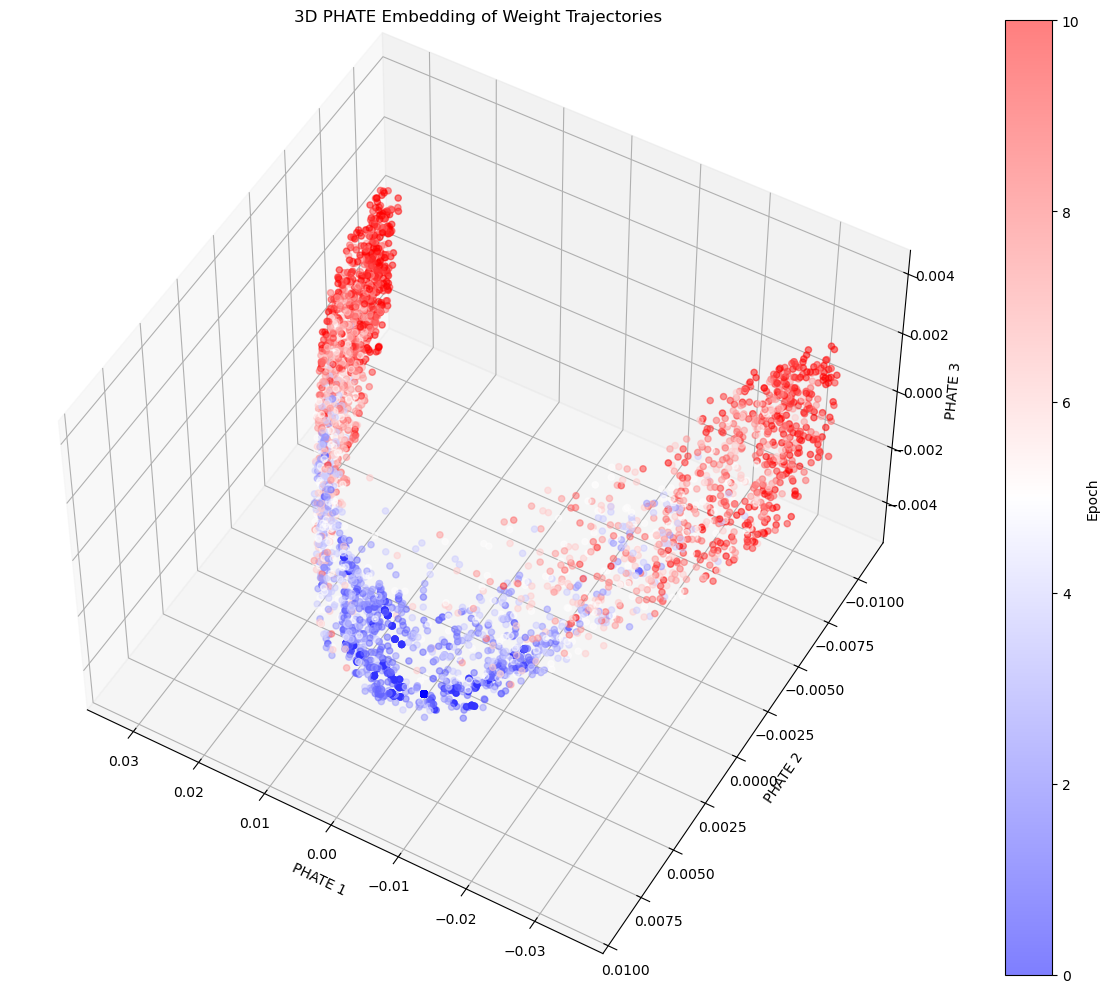

In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], 
                     c=index_array_flat, alpha=0.5, cmap='bwr')

ax.set_title('3D PHATE Embedding of Weight Trajectories')
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')
ax.set_zlabel('PHATE 3')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

# Rotate the plot to put the common branching point in the bottom left corner
ax.view_init(elev=50, azim=120)

plt.tight_layout()
plt.show()


In [93]:
# import phate
# import numpy as np

# # Add very small random noise to weights_trajectories_flat
# noise = np.random.normal(0, 1e-6, weights_trajectories_flat.shape)
# weights_trajectories_flat_noisy = weights_trajectories_flat + noise

# reducer = phate.PHATE(knn=300, n_jobs=-1, verbose=True, n_components=3)
# embed = reducer.fit_transform(weights_trajectories_flat_noisy)
# embed.shape

# # Print the shape of the new array to verify
# print(f"Shape of weights_trajectories_array: {weights_trajectories_array.shape}")

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(12, 10))
# ax = fig.add_subplot(111, projection='3d')

# scatter = ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], 
#                      c=index_array_flat, alpha=0.5, cmap='viridis')

# ax.set_title('3D PHATE Embedding of Weight Trajectories')
# ax.set_xlabel('PHATE 1')
# ax.set_ylabel('PHATE 2')
# ax.set_zlabel('PHATE 3')

# # Add a color bar
# cbar = plt.colorbar(scatter)
# cbar.set_label('Epoch')

# # Rotate the plot to put the common branching point in the bottom left corner
# ax.view_init(elev=20, azim=120)

# plt.tight_layout()
# plt.show()


# PaCMAP

In [95]:
import pacmap
import numpy as np

# Add very small random noise to weights_trajectories_flat
# noise = np.random.normal(0, 1e-6, weights_trajectories_flat.shape)
# weights_trajectories_flat_noisy = weights_trajectories_flat + noise

reducer = pacmap.PaCMAP(n_components=3, n_neighbors=100, verbose=True)
embed = reducer.fit_transform(weights_trajectories_flat)
embed.shape

# Print the shape of the new array to verify
print(f"Shape of weights_trajectories_array: {weights_trajectories_array.shape}")


X is normalized
PaCMAP(n_neighbors=100, n_MN=50, n_FP=200, distance=euclidean, lr=1.0, n_iters=(100, 100, 250), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((396000, 2), (198000, 2), (792000, 2))
Initial Loss: 487970.375
Iteration:   10, Loss: 337091.562500
Iteration:   20, Loss: 314254.031250
Iteration:   30, Loss: 301811.250000
Iteration:   40, Loss: 291570.281250
Iteration:   50, Loss: 281369.250000
Iteration:   60, Loss: 270476.000000
Iteration:   70, Loss: 258933.375000
Iteration:   80, Loss: 245989.406250
Iteration:   90, Loss: 230655.343750
Iteration:  100, Loss: 210733.500000
Iteration:  110, Loss: 267738.531250
Iteration:  120, Loss: 266983.031250
Iteration:  130, Loss: 266727.937500
Iteration:  140, Loss: 266658.812500
Iteration:  150, Loss: 266634.187500
Iteration:  160, Loss: 266577.875000
Iteration:  170, Loss: 266626.937500
Iteration:  18

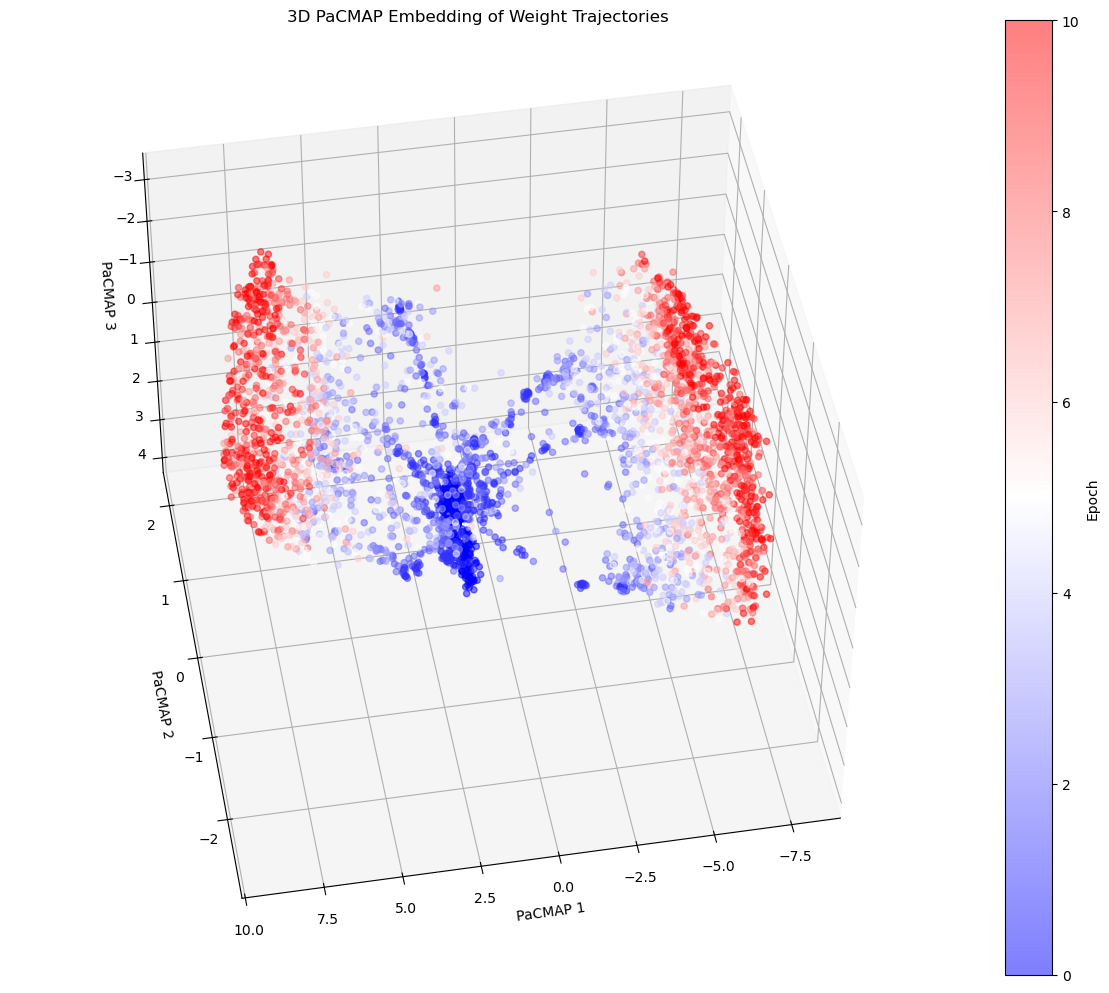

In [105]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], 
                     c=index_array_flat, alpha=0.5, cmap='bwr')

ax.set_title('3D PaCMAP Embedding of Weight Trajectories')
ax.set_xlabel('PaCMAP 1')
ax.set_ylabel('PaCMAP 2')
ax.set_zlabel('PaCMAP 3')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

# Rotate the plot to put the common branching point in the bottom left corner
ax.view_init(elev=-135, azim=100)

plt.tight_layout()
plt.show()
